# Bayesian Equivalence Testing

## Step 1: Import libraries

In [28]:
import getpass
import pathlib
import os
import pandas as pd
import mat4py
import numpy as np
import math
import pickle
from more_itertools import unique_everseen
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
from statsmodels.formula.api import ols, mixedlm
from random import shuffle
from scipy import stats
from scipy.stats import mstats, skew, boxcox, pearsonr, f_oneway
import scipy.io
from statistics import mean, stdev, median
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
import dataframe_image as dfi
# from pymc3 import *
from pymc3 import plot_posterior
import pystan.misc as pymisc
import arviz as az
from collections import OrderedDict
# import abyes
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')
sns.set_context('poster')
os.environ['R_HOME'] = 'C:/Users/kjl113/Anaconda3/lib/R'

from rpy2.robjects import r, pandas2ri, conversion
from rpy2.robjects.packages import importr
pandas2ri.activate()
bayestest = importr('bayestestR')
reffectsize = importr('effectsize')
rlogs = importr('logspline')
rbase = importr('base')
r("nullfn = function(){NULL}")
rnull = r.nullfn()
r("inffn = function(){Inf}")
rinf = r.inffn()

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
azdf1 = az.from_netcdf('standardddm.nc')
azdf2 = az.from_netcdf('standardraceddm.nc')
azdf3 = az.from_netcdf('standardraceallddm.nc')
azdf4 = az.from_netcdf('facesddm.nc')

In [17]:
print(azdf3.posterior.mu_beta_black_angry.mean(dim=['chain', 'draw']))
print(azdf3.posterior.mu_beta_white_angry.mean(dim=['chain', 'draw']))
print(azdf3.posterior.mu_beta_black_happy.mean(dim=['chain', 'draw']))
print(azdf3.posterior.mu_beta_white_happy.mean(dim=['chain', 'draw']))

<xarray.DataArray 'mu_beta_black_angry' ()>
array(0.96908242)
<xarray.DataArray 'mu_beta_white_angry' ()>
array(0.98802037)
<xarray.DataArray 'mu_beta_black_happy' ()>
array(0.96183932)
<xarray.DataArray 'mu_beta_white_happy' ()>
array(0.98965578)


param          ess      rhat
0   alpha_happy  6101.040992  1.000222
1   alpha_angry  6452.322579  1.000457
2     zed_happy  7388.813712  1.000422
3     zed_angry  7703.285008  1.000139
4  lambda_happy  3475.412318  0.999993
5  lambda_angry  3184.001007  1.000840

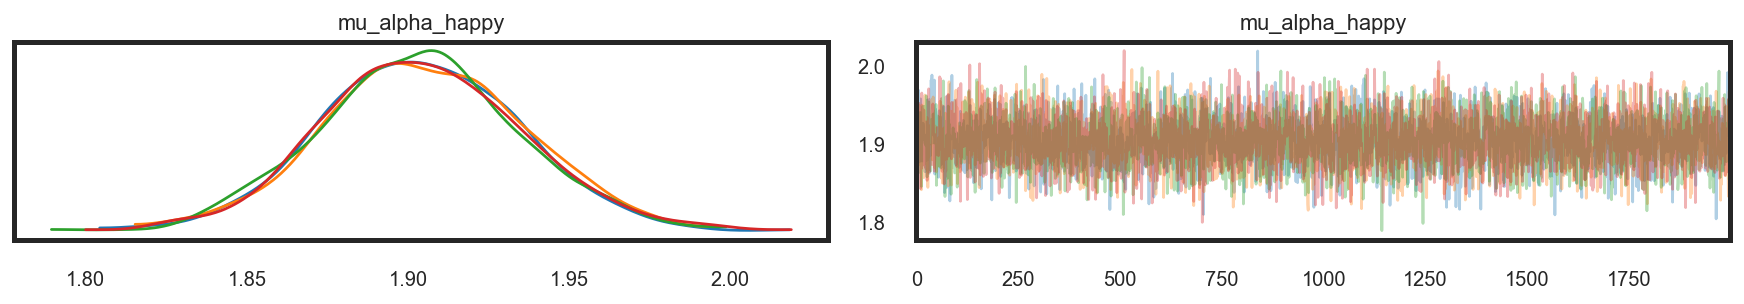

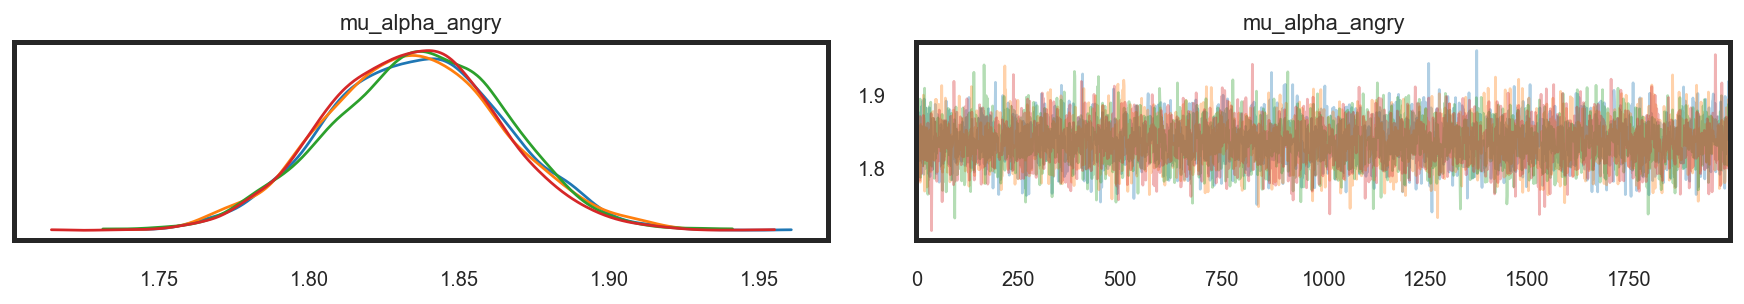

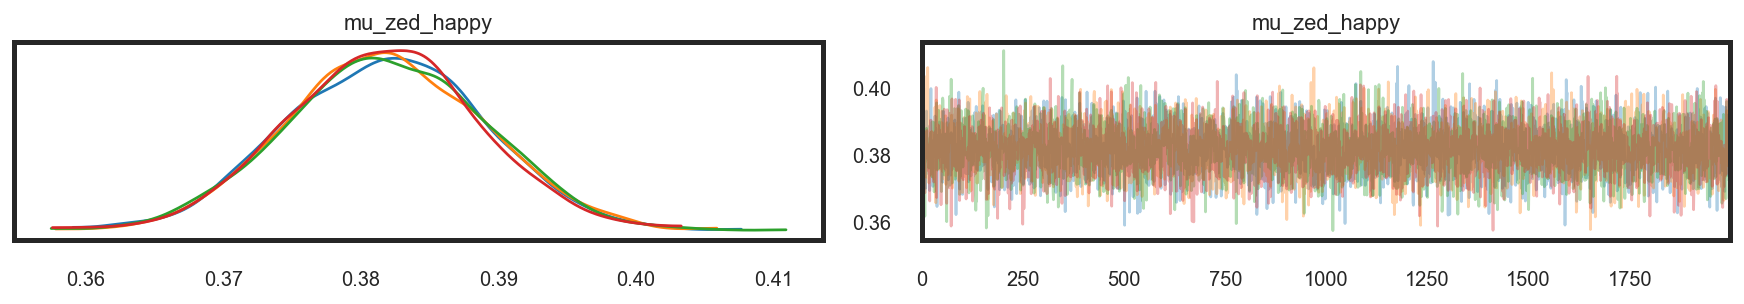

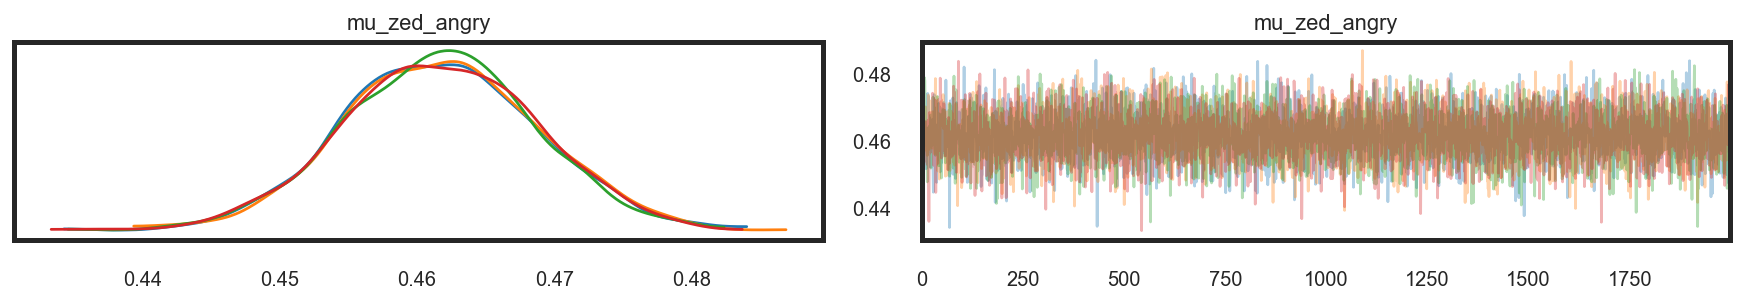

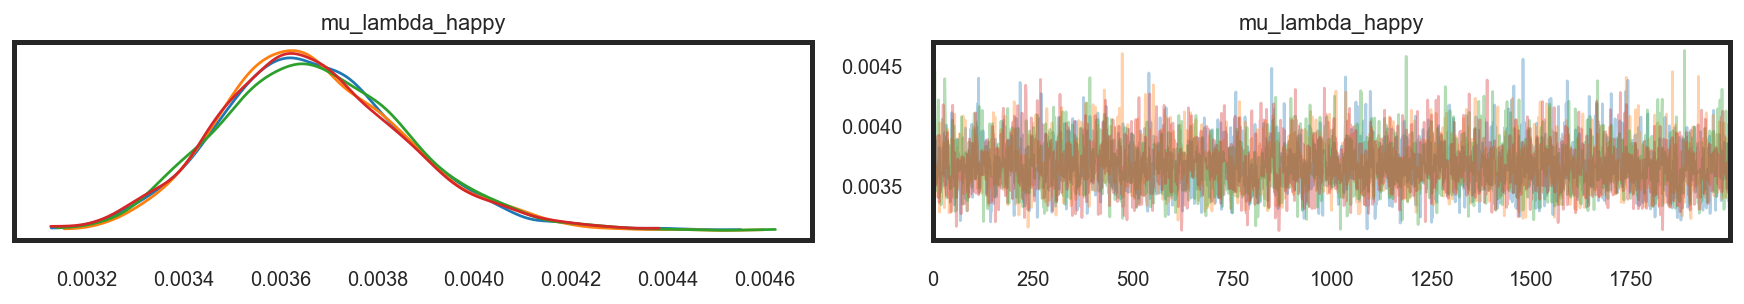

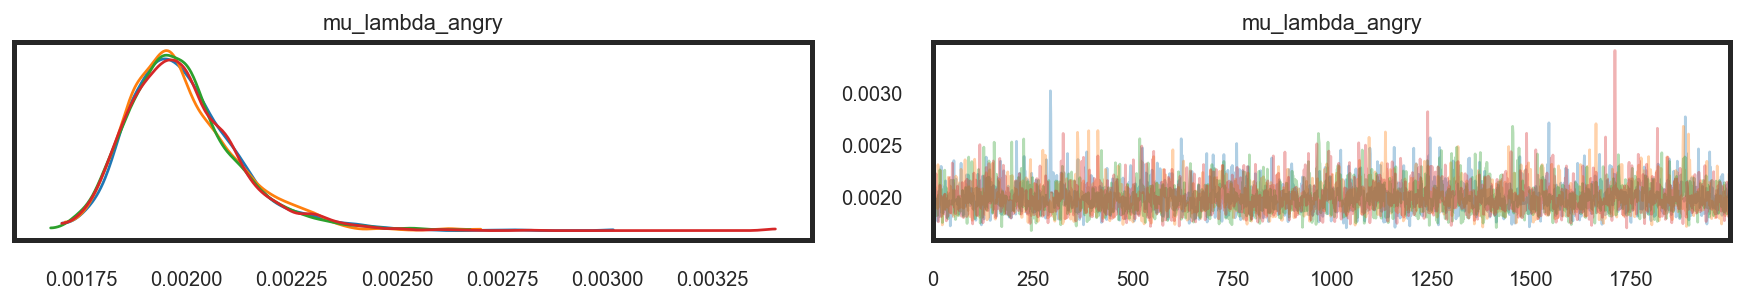

In [21]:
essdf = az.ess(azdf3)
rhatdf = az.rhat(azdf3)
varlist = []; esslist = []; rhatlist = []
for x in ['alpha', 'zed', 'lambda']:
    for y in ['happy', 'angry']:
        varlist.append(x+'_'+y)
        az.plot_trace(azdf3, var_names=("mu_"+x+"_"+y))
        esslist.append(float(essdf["mu_"+x+"_"+y].values))
        rhatlist.append(float(rhatdf["mu_"+x+"_"+y].values))
pd.DataFrame({'param': varlist, 'ess': esslist, 'rhat': rhatlist})

param          ess      rhat
0   beta_happy  4539.204661  1.000209
1   beta_happy  3642.919192  1.000557
2   beta_angry  3716.217662  1.000808
3   beta_angry  3735.826228  1.000708
4  gamma_happy  7987.190265  1.000236
5  gamma_happy  8161.821035  0.999802
6  gamma_angry  8217.118189  0.999936
7  gamma_angry  8429.745856  0.999774

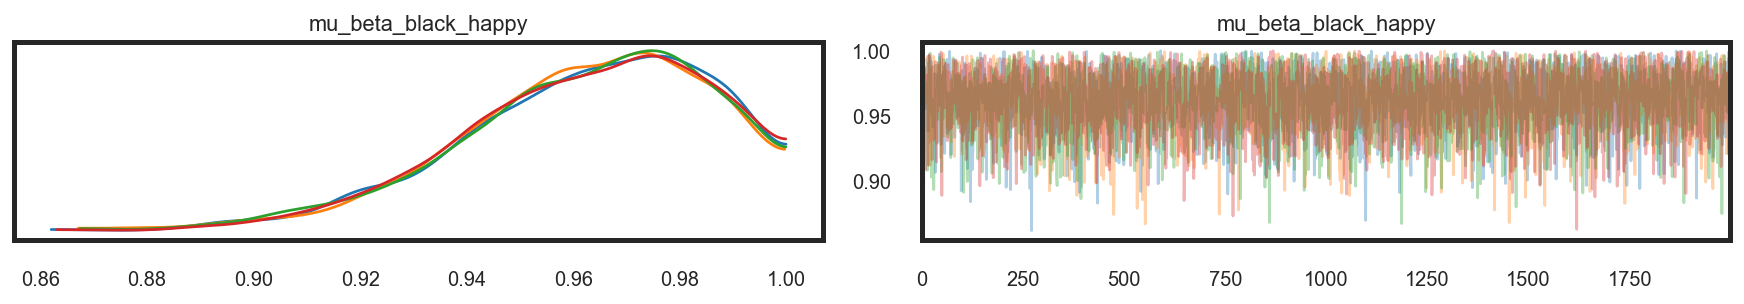

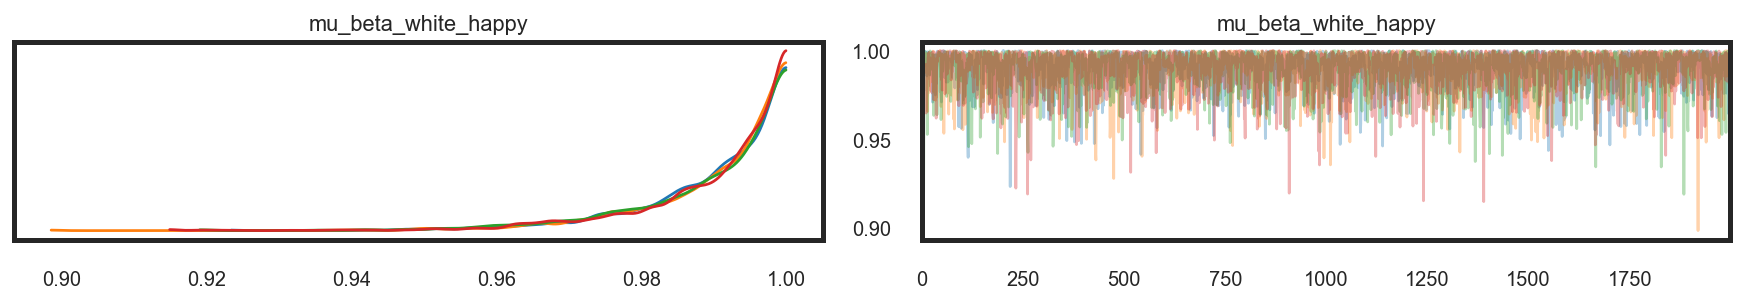

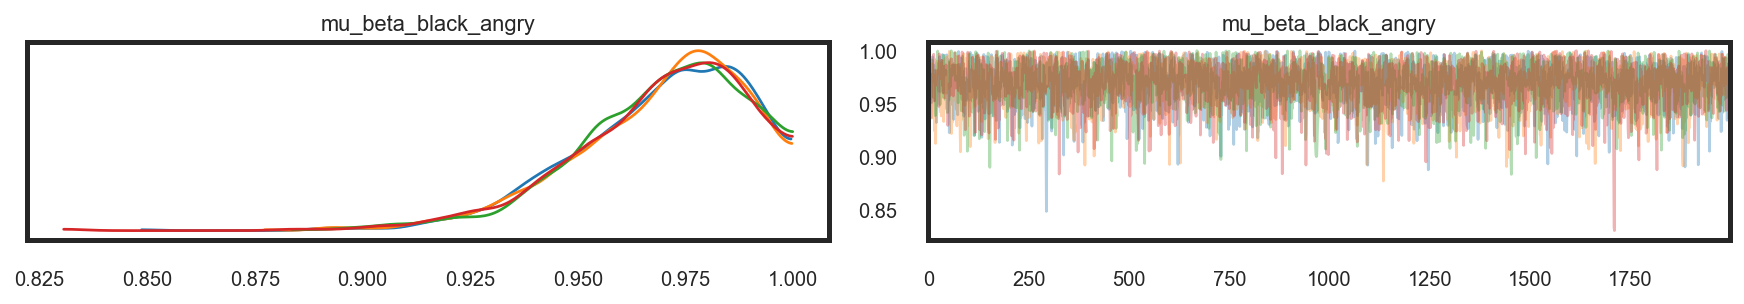

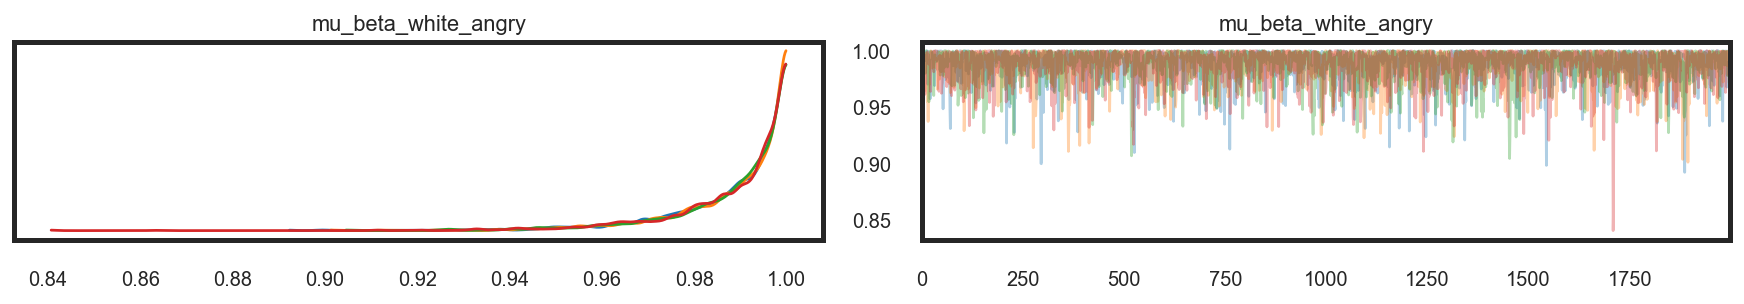

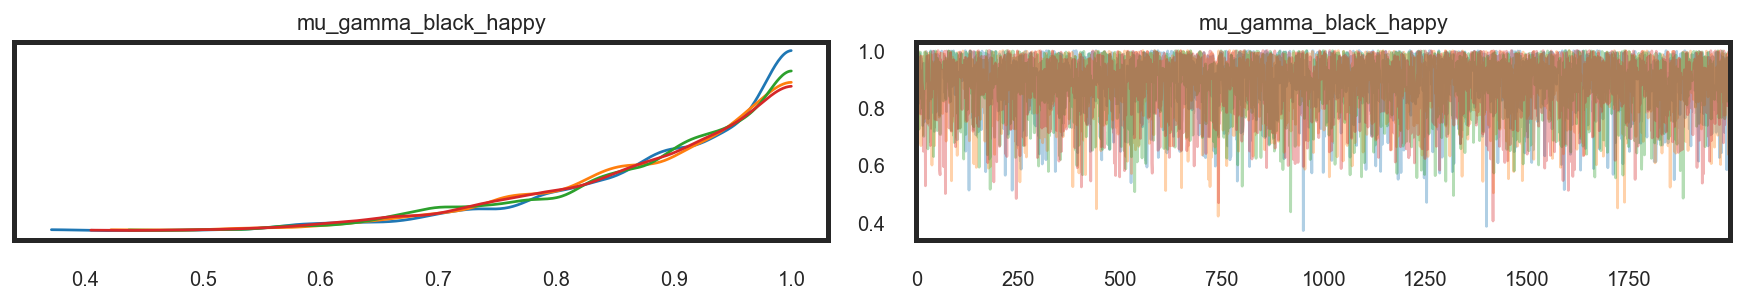

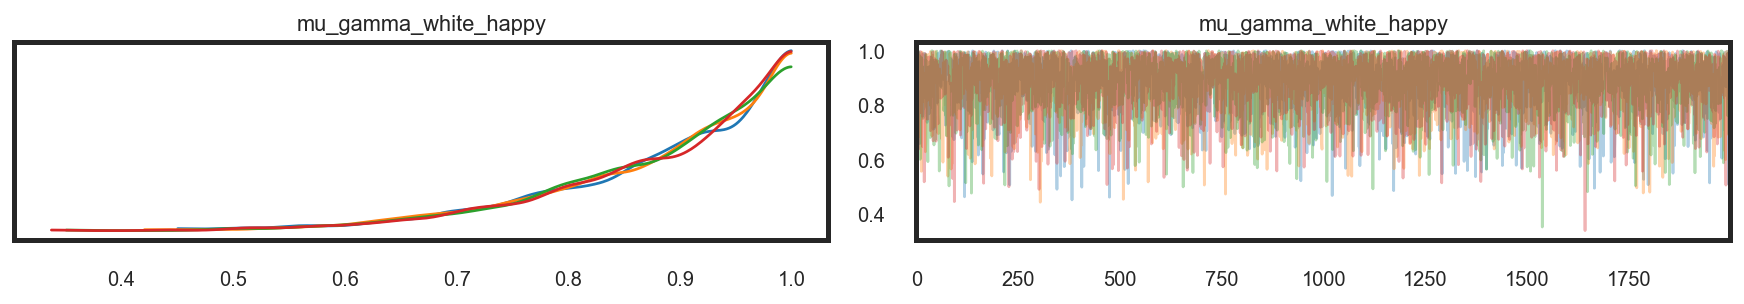

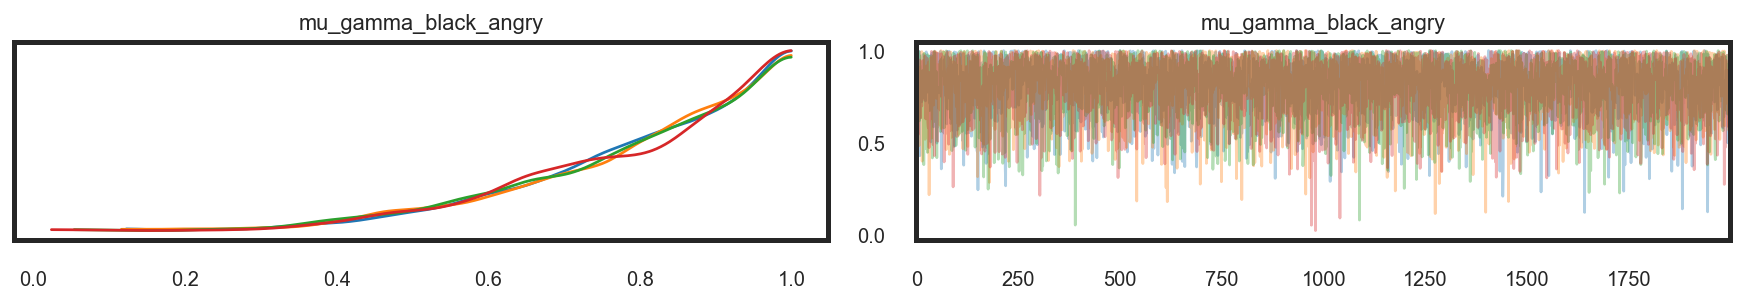

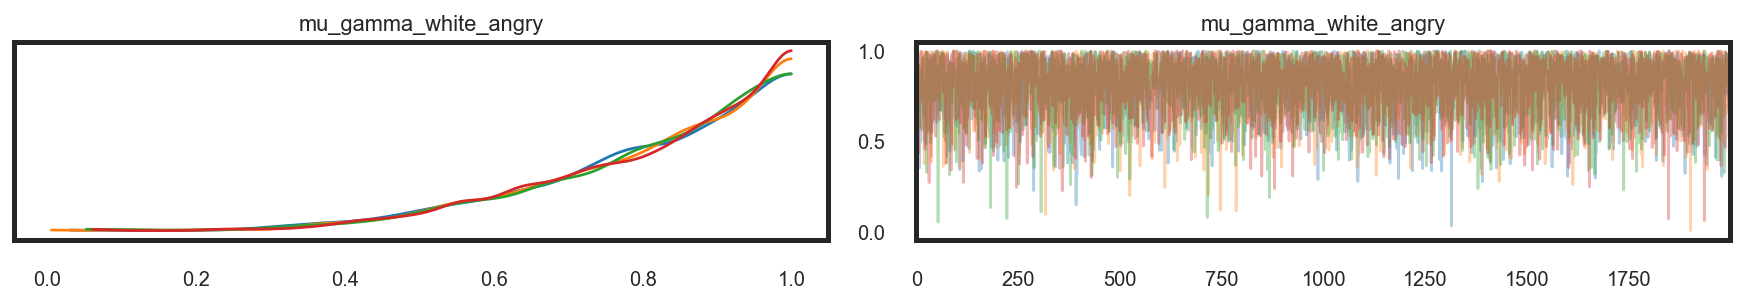

In [20]:
essdf = az.ess(azdf3)
rhatdf = az.rhat(azdf3)
varlist = []; esslist = []; rhatlist = []
for x in ['beta', 'gamma']:
    for y in ['happy', 'angry']:
        for z in ['black', 'white']:
            varlist.append(x+'_'+y)
            az.plot_trace(azdf3, var_names=("mu_"+x+"_"+z+"_"+y))
            esslist.append(float(essdf["mu_"+x+"_"+z+"_"+y].values))
            rhatlist.append(float(rhatdf["mu_"+x+"_"+z+"_"+y].values))
pd.DataFrame({'param': varlist, 'ess': esslist, 'rhat': rhatlist})


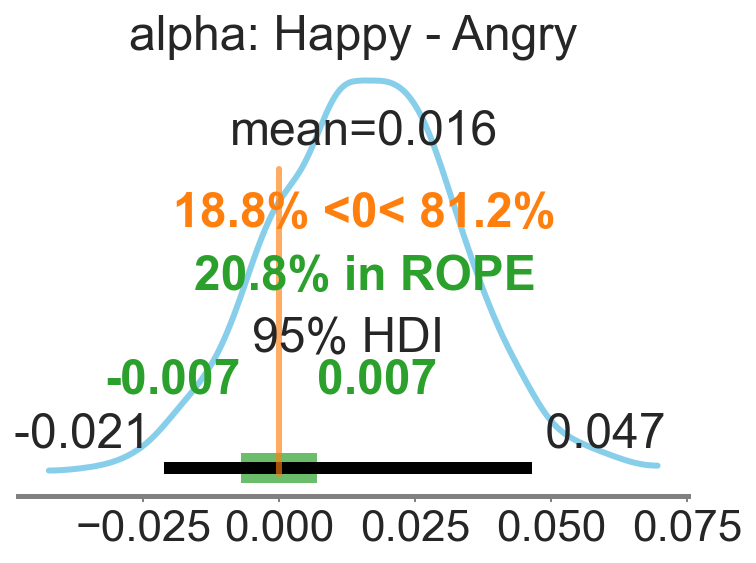

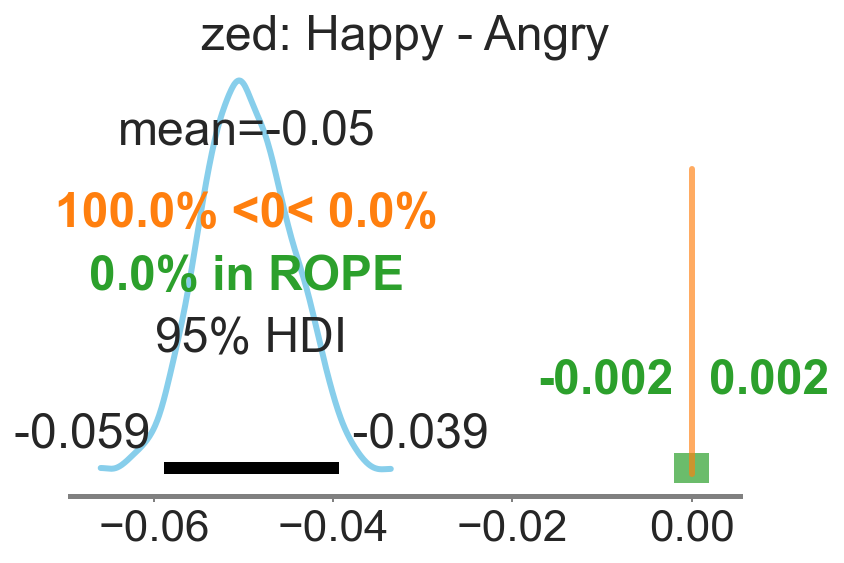

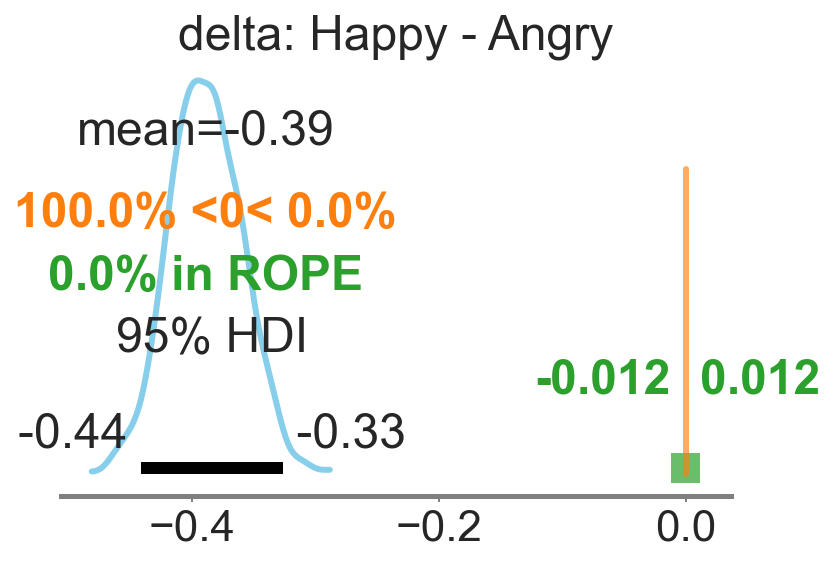

In [517]:
convdict = {'_happy': 'Happy', '_angry': 'Angry'}
# convdict = {'mu_}
interdict = {'alpha': ['more accuracy but slower', 'more speed but less accurate'],
             'zed': ['bias toward emotion', 'bias toward no emotion'],
            'delta': ['more drift', 'less drift']}
hdint = 0.95
effectsize = 0.8

compdict={}
for x in ['alpha', 'zed', 'delta']:
    compdf = pd.DataFrame({'reference':convdict.values()})
    for i, y in enumerate(convdict.keys()):
        compdftemp = []
        for j, z in enumerate(convdict.keys()):
            if i < j:
                sdf = pd.DataFrame({'mu_'+x+y: azdf1.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                   'mu_'+x+z: azdf1.posterior['mu_'+x+z].mean(dim=['chain']).values})
                var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                rope = [float(round(-(effectsize/2)*stdev(list(var)),3)), float(round((effectsize/2)*stdev(list(var)),3))]
                hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                vart = {'%s: %s' % (x, convdict[y]+' - '+convdict[z]): np.array(var)}
                plot_posterior(vart, color='#87ceeb', 
                  rope=rope, point_estimate='mean',
                  ref_val=0, hdi_prob=hdint)
                if rope[1] < hdi[1]:
                    compdftemp.append(interdict[x][0])
                elif rope[0] > hdi[2]:
                    compdftemp.append(interdict[x][1])
                else:
                    compdftemp.append('=')
            else:
                compdftemp.append('')
        compdf[convdict[y]] = compdftemp
    compdict[x] = compdf

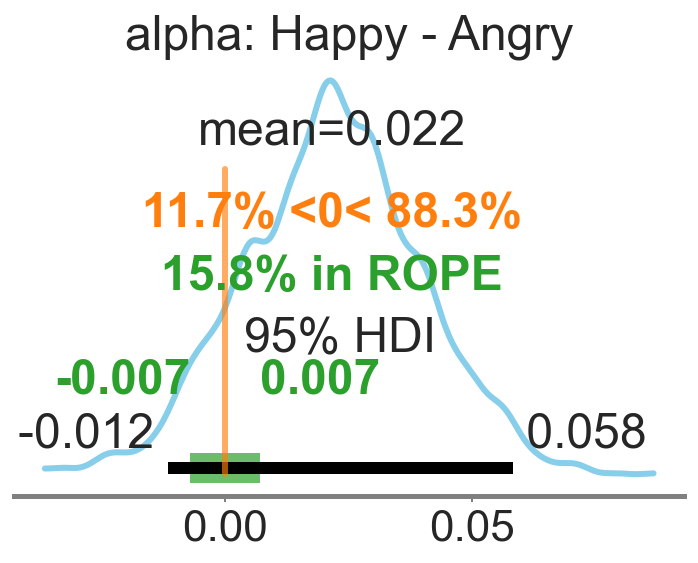

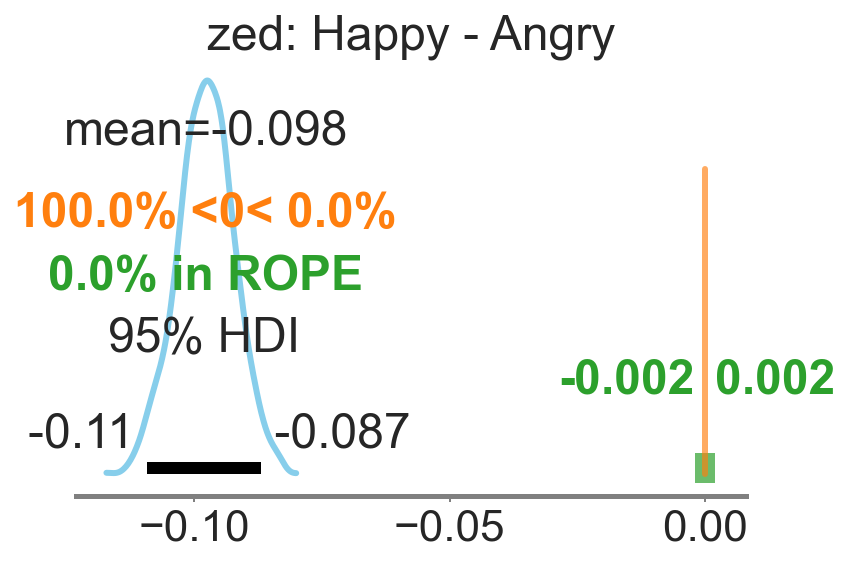

In [516]:
convdict = {'_happy': 'Happy', '_angry': 'Angry'}
# convdict = {'mu_}
interdict = {'alpha': ['more accuracy but slower', 'more speed but less accurate'],
             'zed': ['bias toward emotion', 'bias toward no emotion']}
hdint = 0.95
effectsize = 0.8

compdict={}
for x in ['alpha', 'zed']:
    compdf = pd.DataFrame({'reference':convdict.values()})
    for i, y in enumerate(convdict.keys()):
        compdftemp = []
        for j, z in enumerate(convdict.keys()):
            if i < j:
                sdf = pd.DataFrame({'mu_'+x+y: azdf2.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                   'mu_'+x+z: azdf2.posterior['mu_'+x+z].mean(dim=['chain']).values})
                var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                rope = [float(round(-(effectsize/2)*stdev(list(var)),3)), float(round((effectsize/2)*stdev(list(var)),3))]
                hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                vart = {'%s: %s' % (x, convdict[y]+' - '+convdict[z]): np.array(var)}
                plot_posterior(vart, color='#87ceeb', 
                  rope=rope, point_estimate='mean',
                  ref_val=0, hdi_prob=hdint)
                if rope[1] < hdi[1]:
                    compdftemp.append(interdict[x][0])
                elif rope[0] > hdi[2]:
                    compdftemp.append(interdict[x][1])
                else:
                    compdftemp.append('=')
            else:
                compdftemp.append('')
        compdf[convdict[y]] = compdftemp
    compdict[x] = compdf

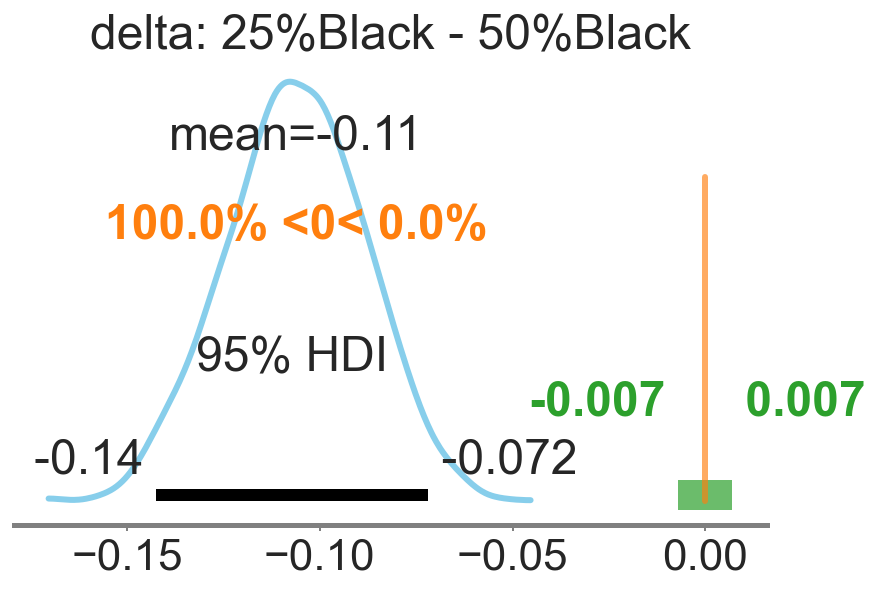

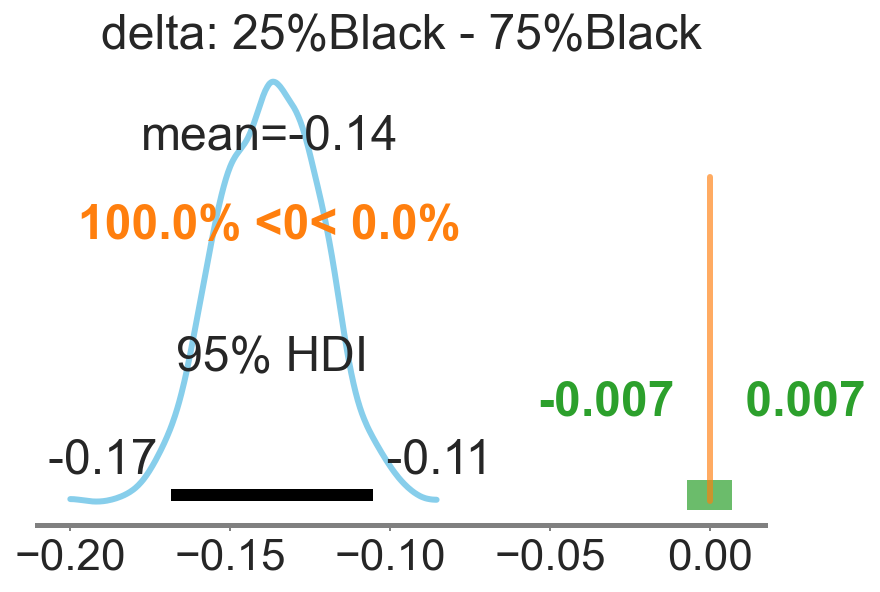

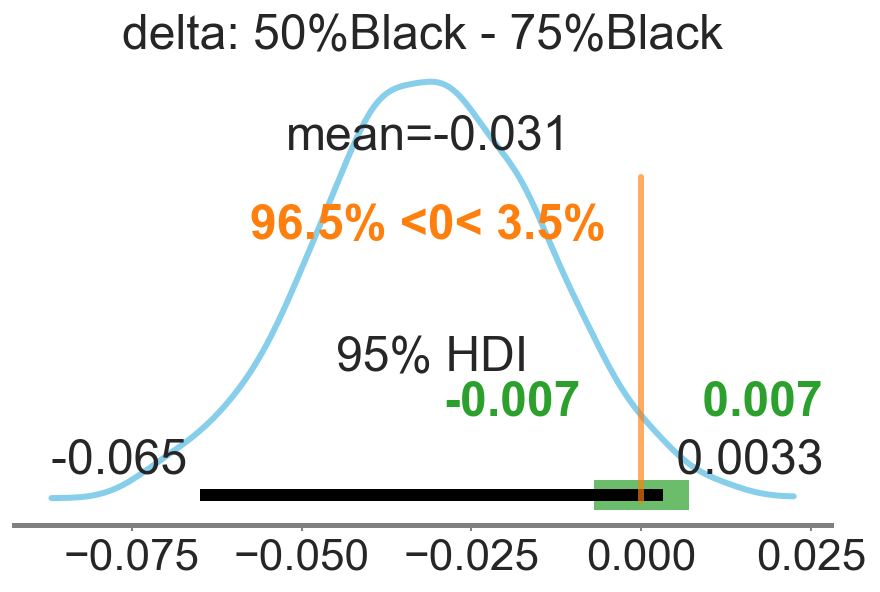

In [7]:
convdict = {'_b25': '25%Black', '_b50': '50%Black', '_b75': '75%Black'}
# convdict = {'mu_}
interdict = {'delta': ['more drift', 'less drift']}
hdint = 0.95
effectsize = 0.8

compdict={}
for x in ['delta']:
    compdf = pd.DataFrame({'reference':convdict.values()})
    for i, y in enumerate(convdict.keys()):
        compdftemp = []
        for j, z in enumerate(convdict.keys()):
            if i < j:
                sdf = pd.DataFrame({'mu_'+x+y: azdf2.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                   'mu_'+x+z: azdf2.posterior['mu_'+x+z].mean(dim=['chain']).values})
                var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                rope = [float(round(-(effectsize/2)*stdev(list(var)),3)), float(round((effectsize/2)*stdev(list(var)),3))]
                hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                vart = {'%s: %s' % (x, convdict[y]+' - '+convdict[z]): np.array(var)}
                plot_posterior(vart, color='#87ceeb', 
                  rope=rope, point_estimate='mean',
                  ref_val=0, hdi_prob=hdint)
                if rope[1] < hdi[1]:
                    compdftemp.append(interdict[x][0])
                elif rope[0] > hdi[2]:
                    compdftemp.append(interdict[x][1])
                else:
                    compdftemp.append('=')
            else:
                compdftemp.append('')
        compdf[convdict[y]] = compdftemp
    compdict[x] = compdf

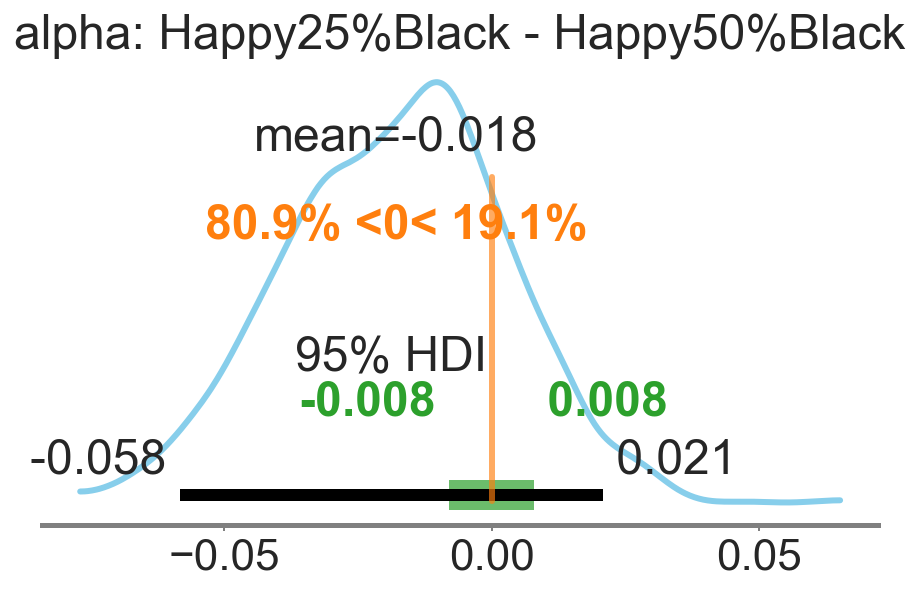

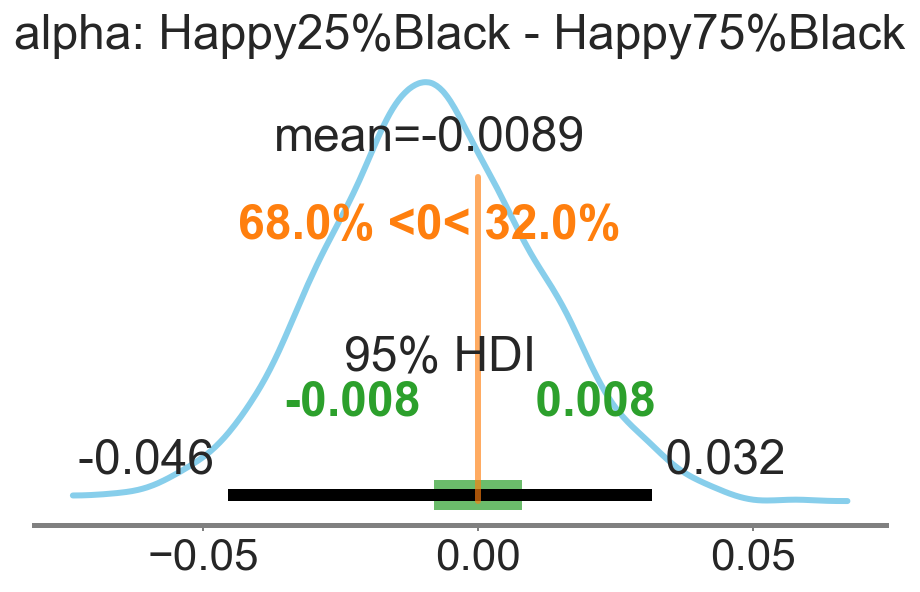

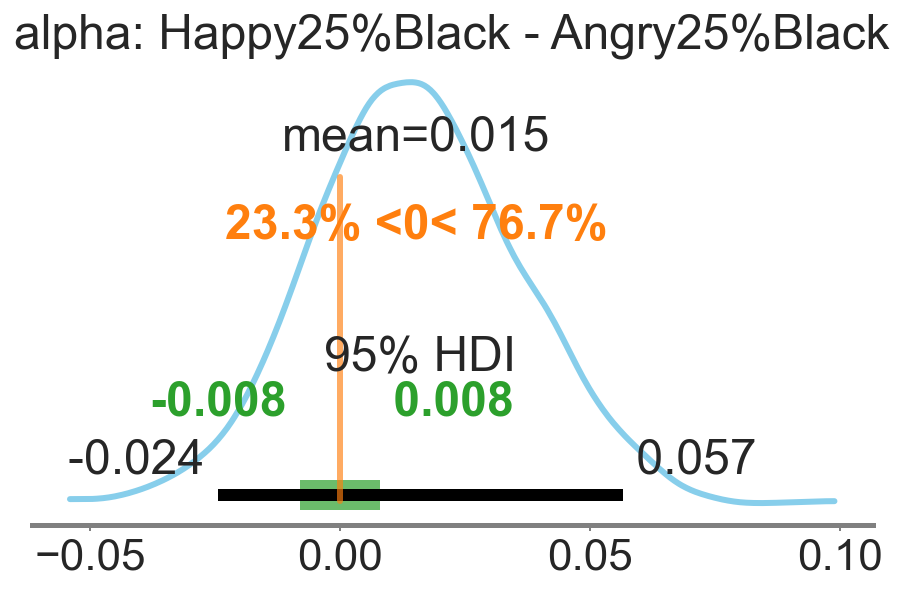

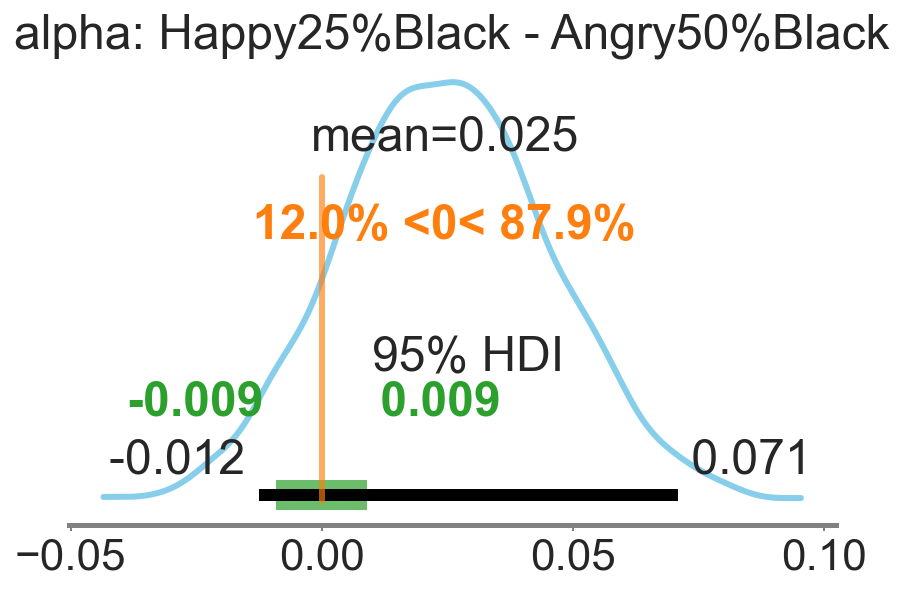

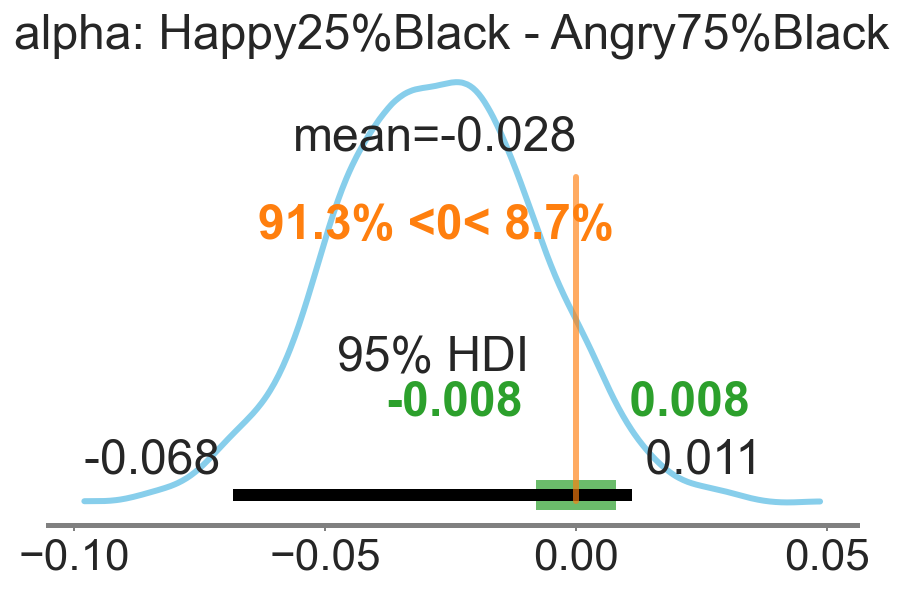

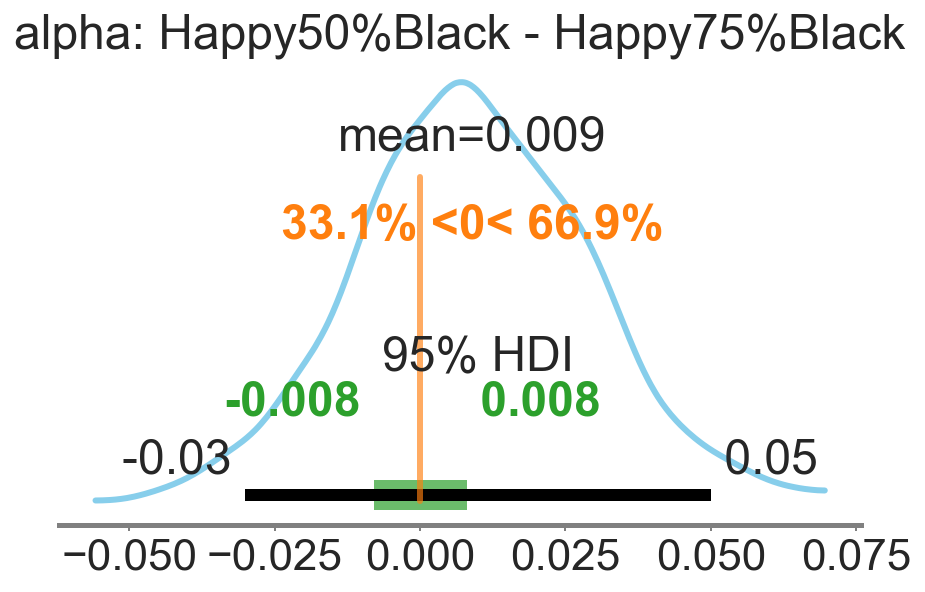

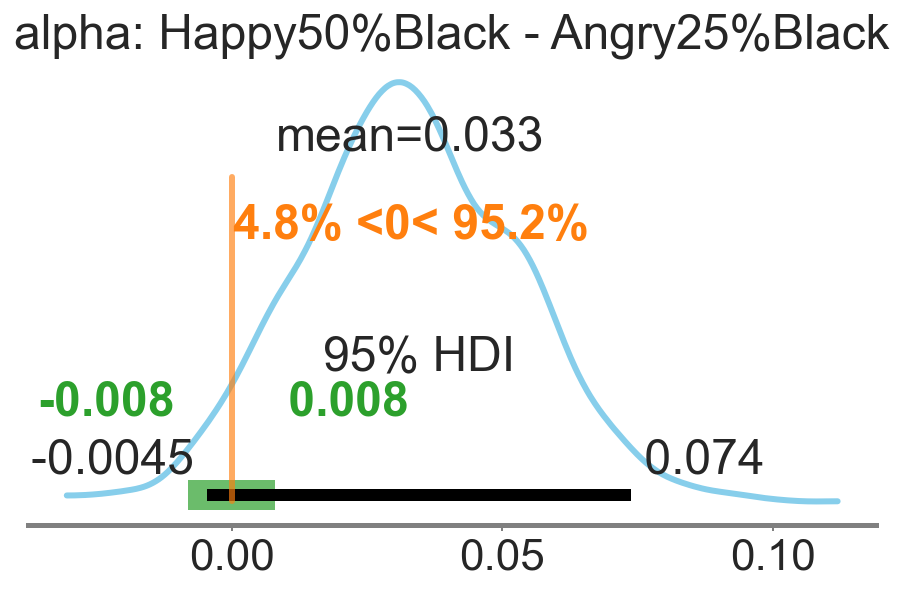

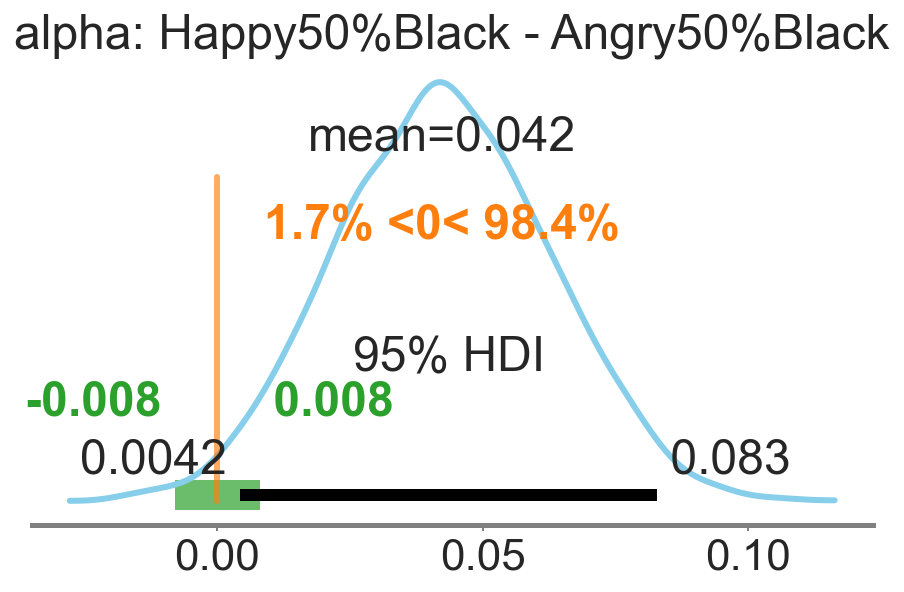

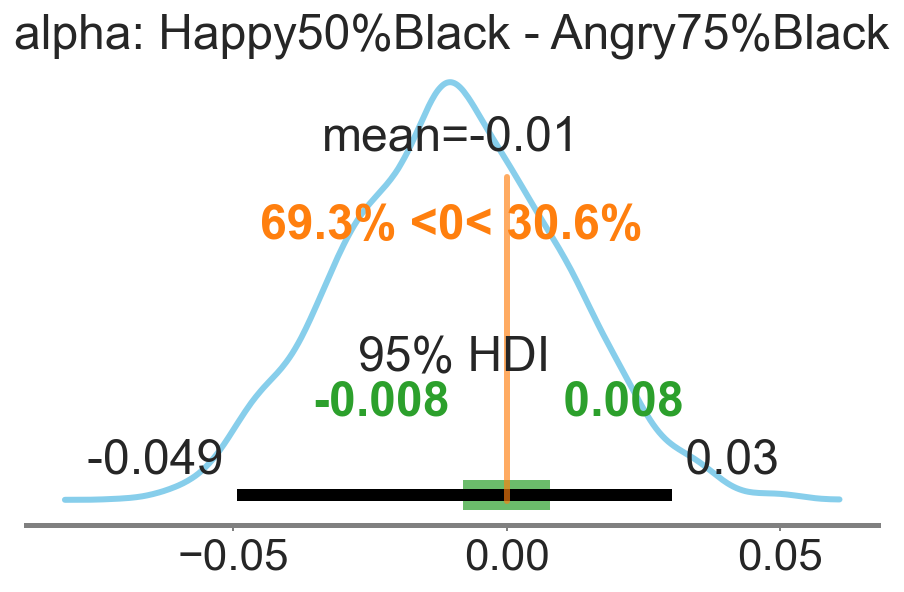

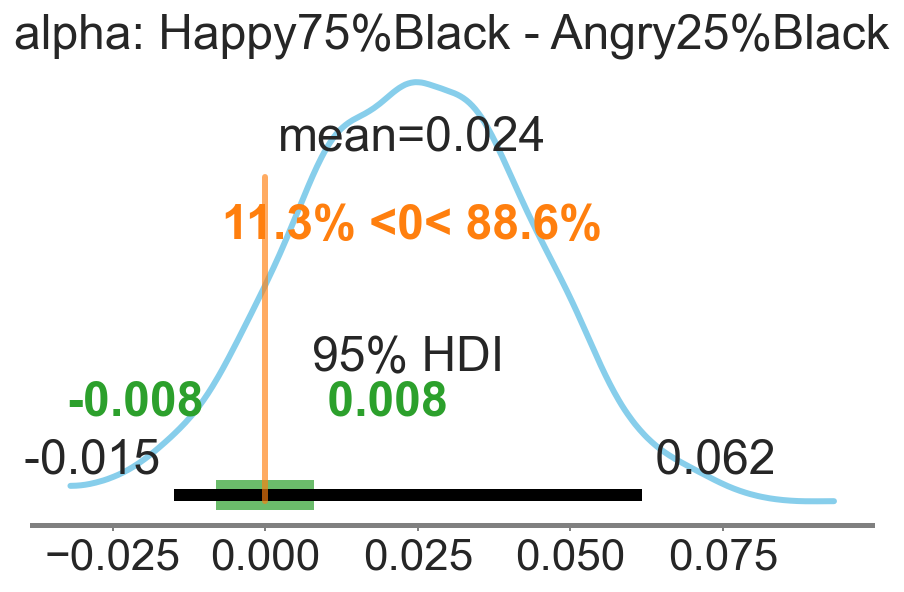

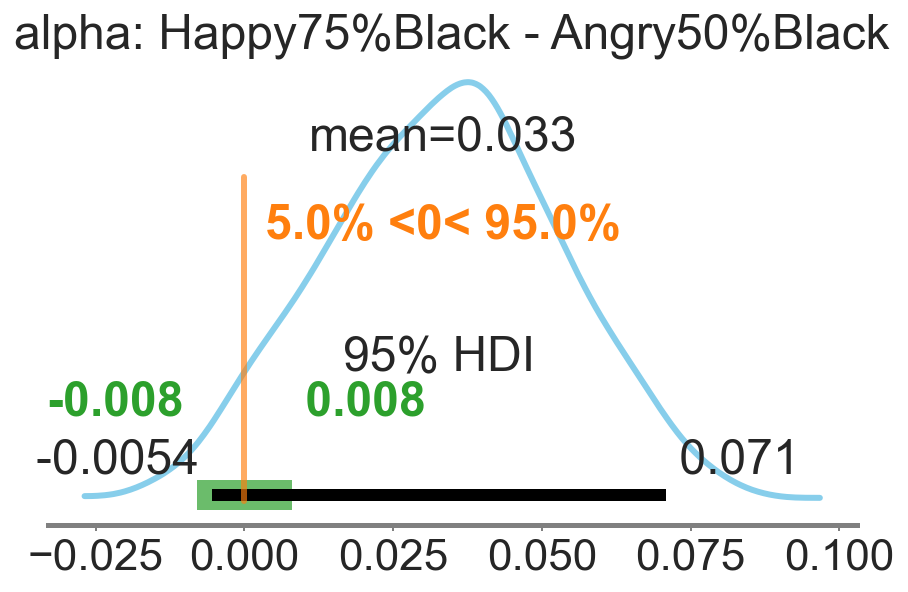

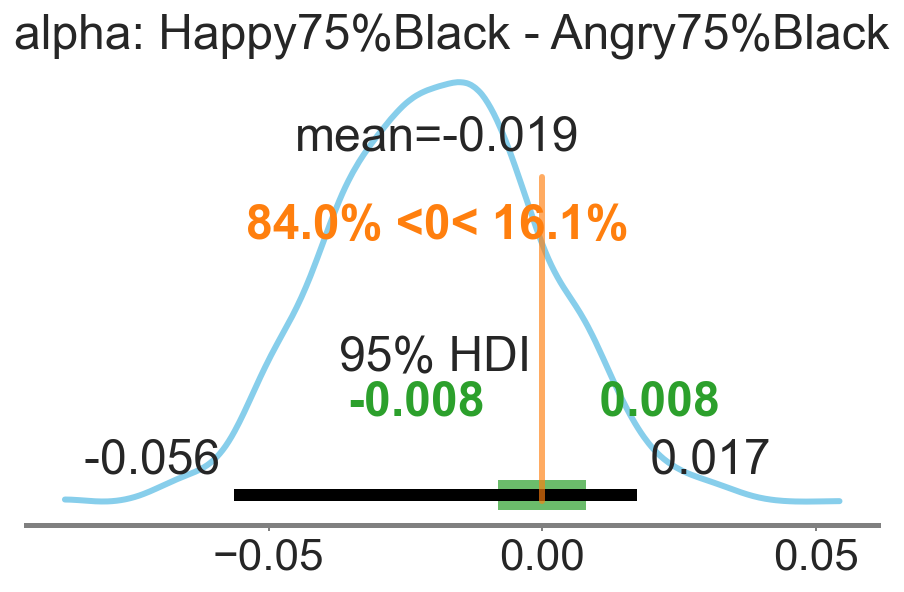

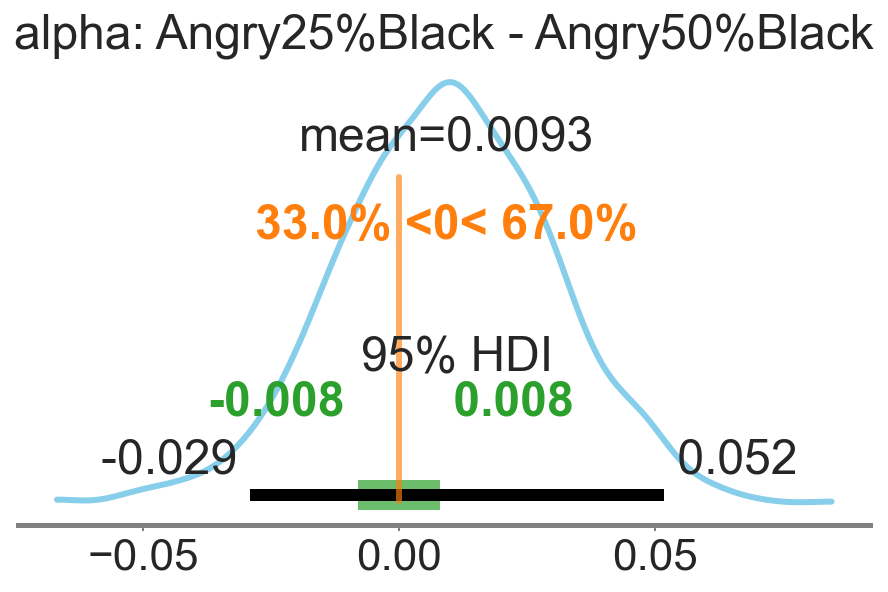

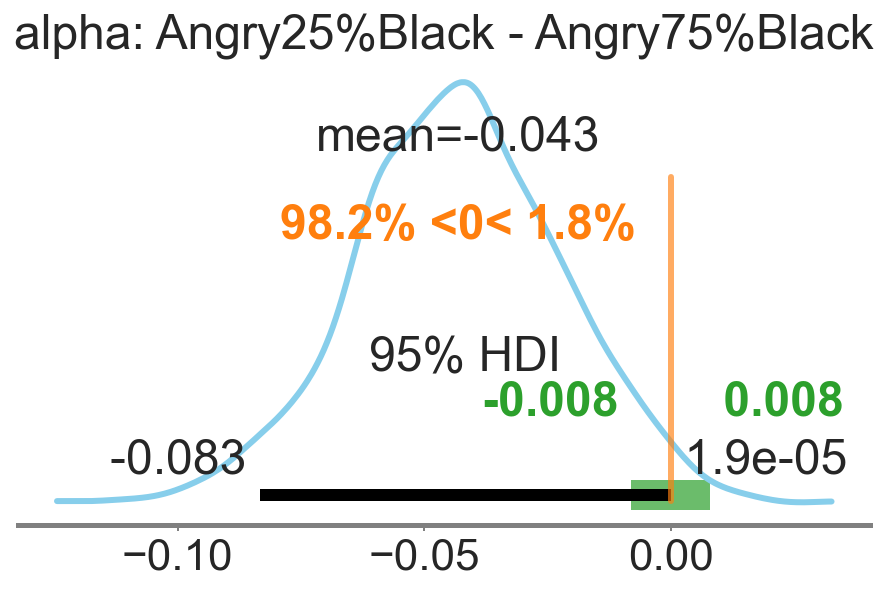

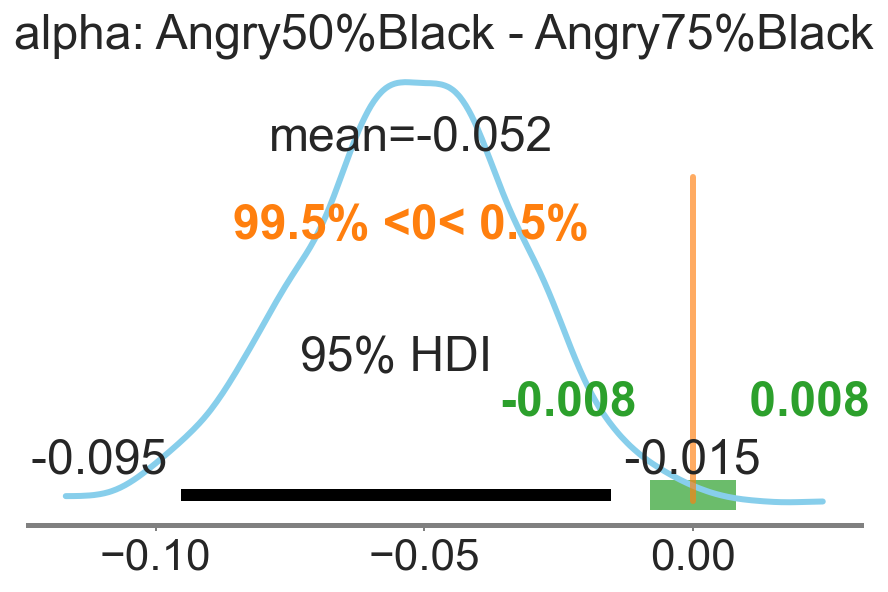

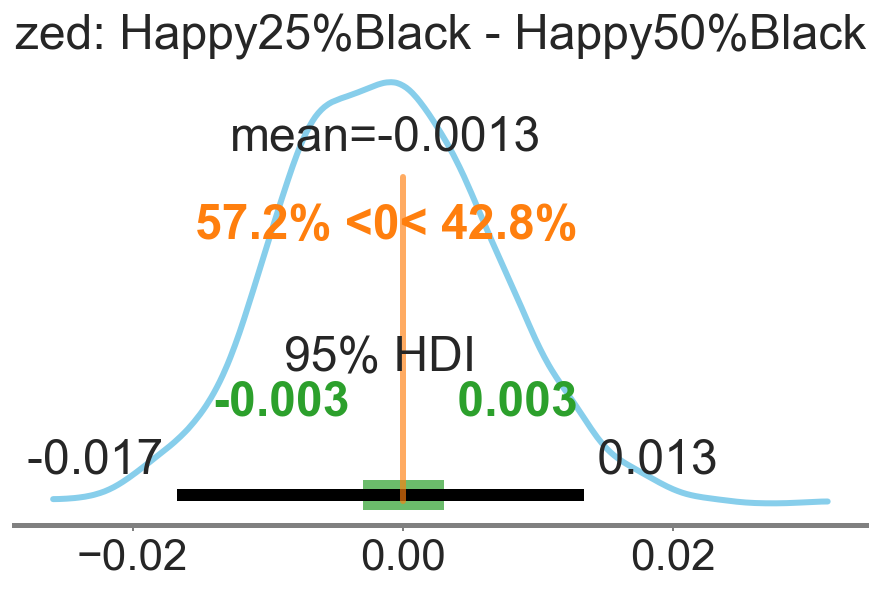

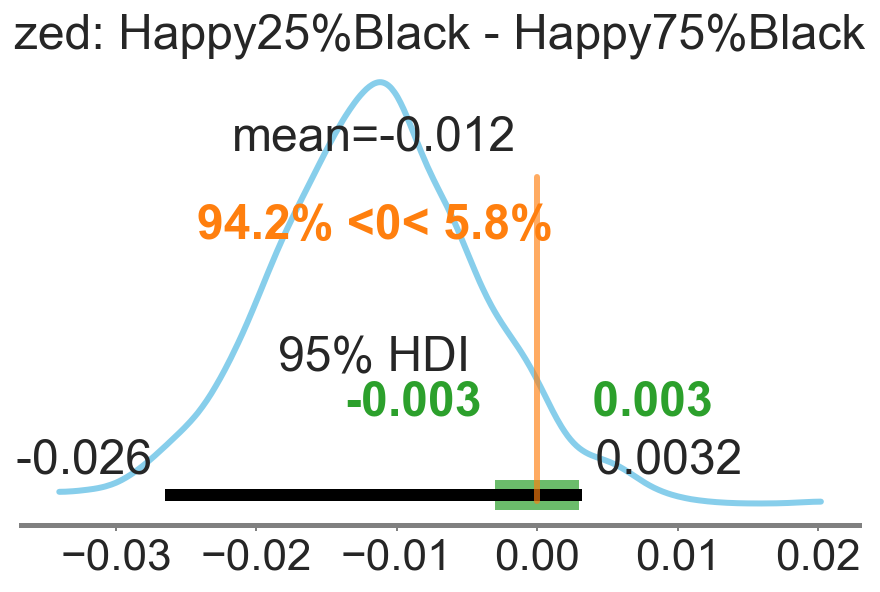

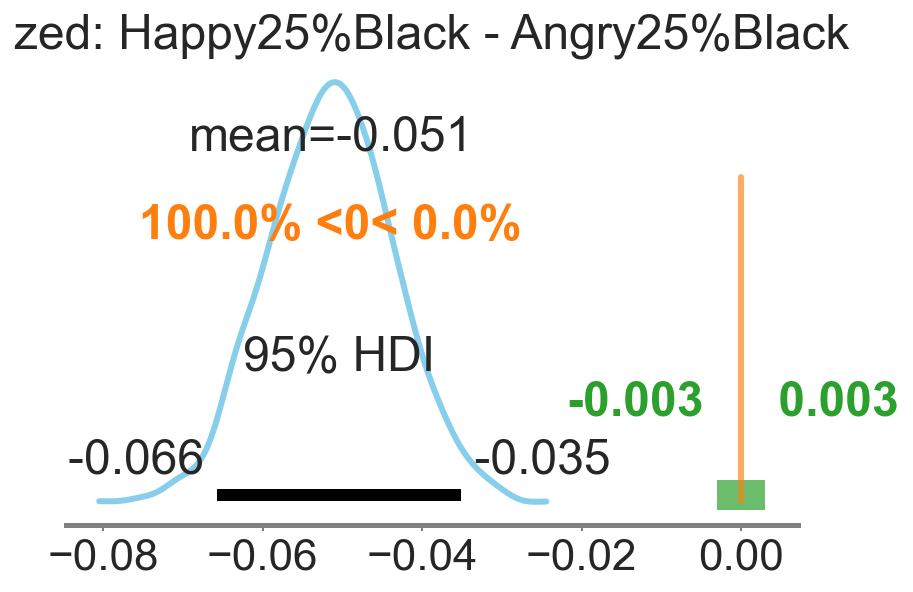

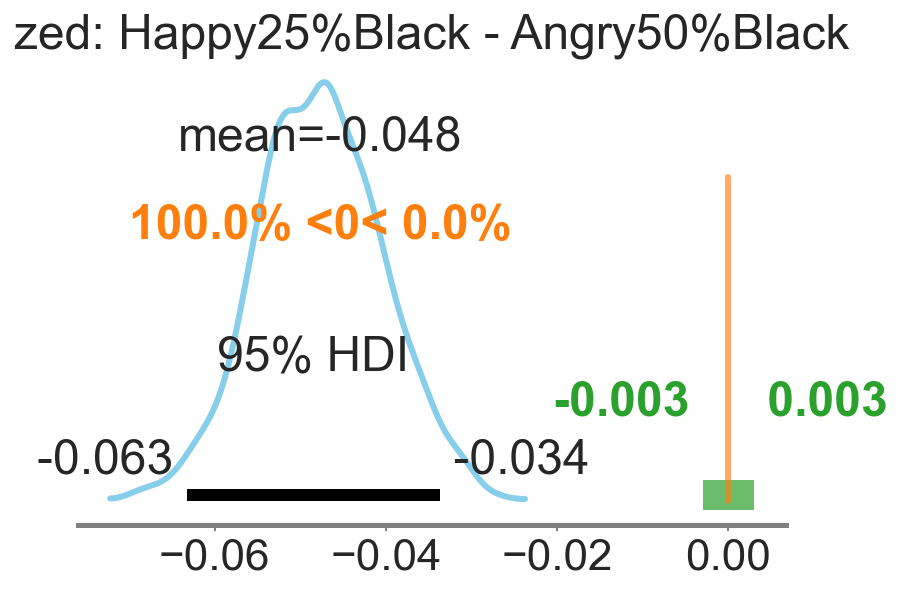

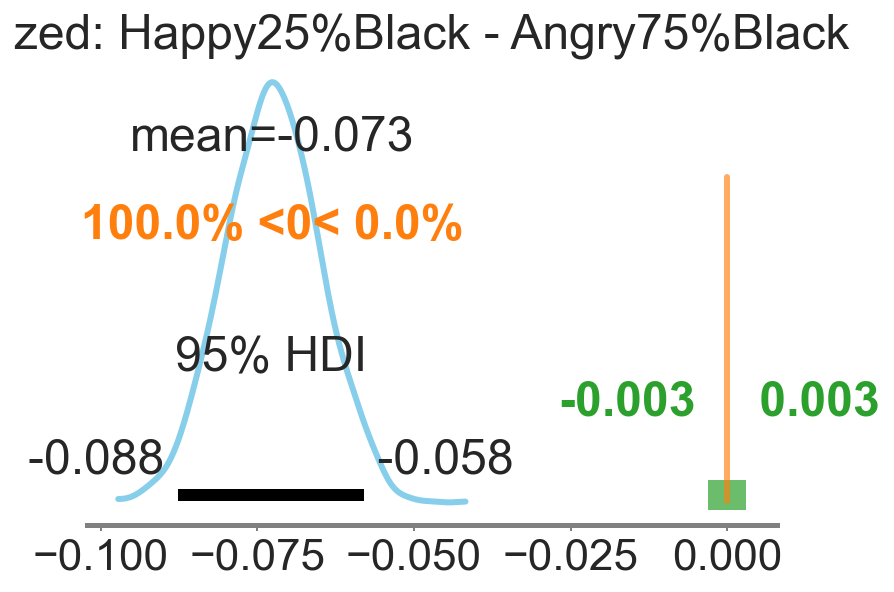

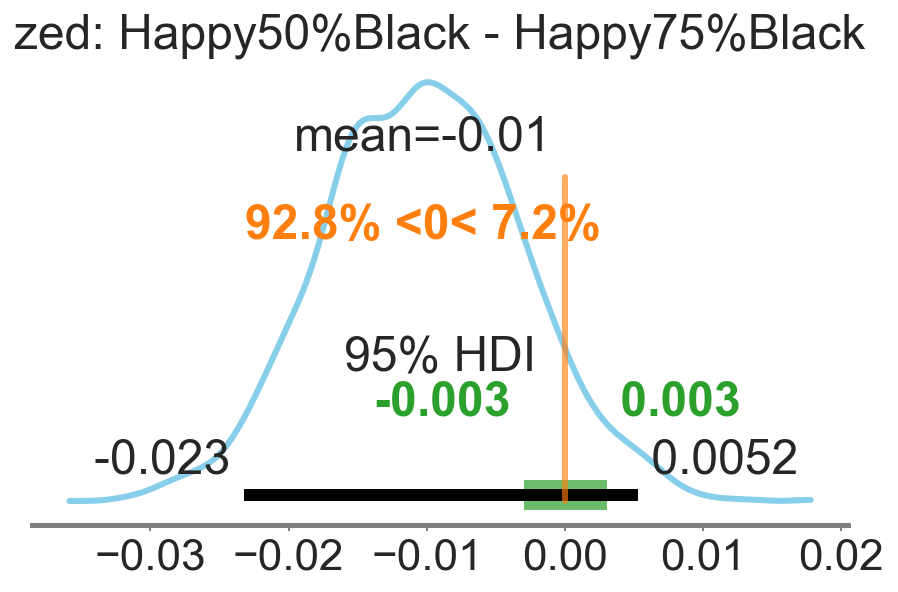

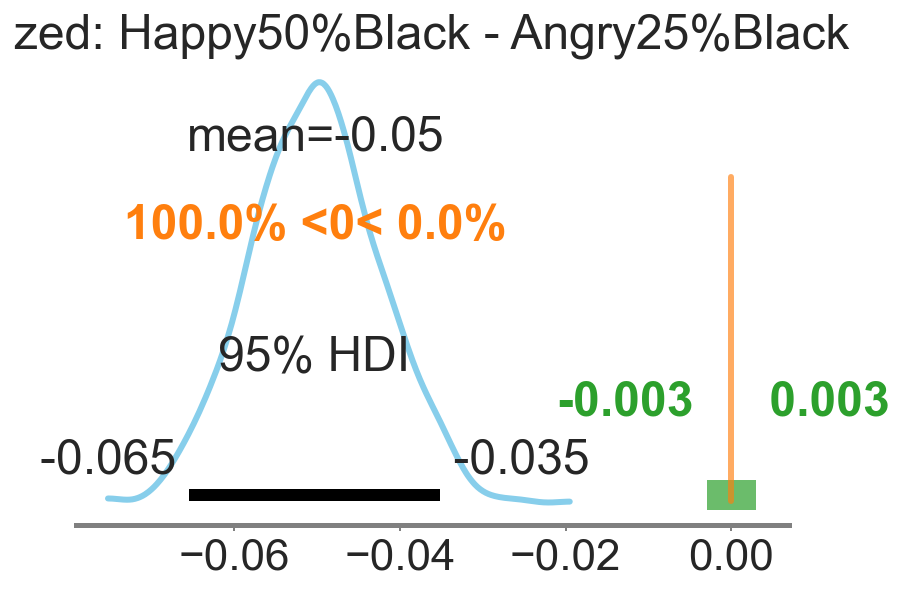

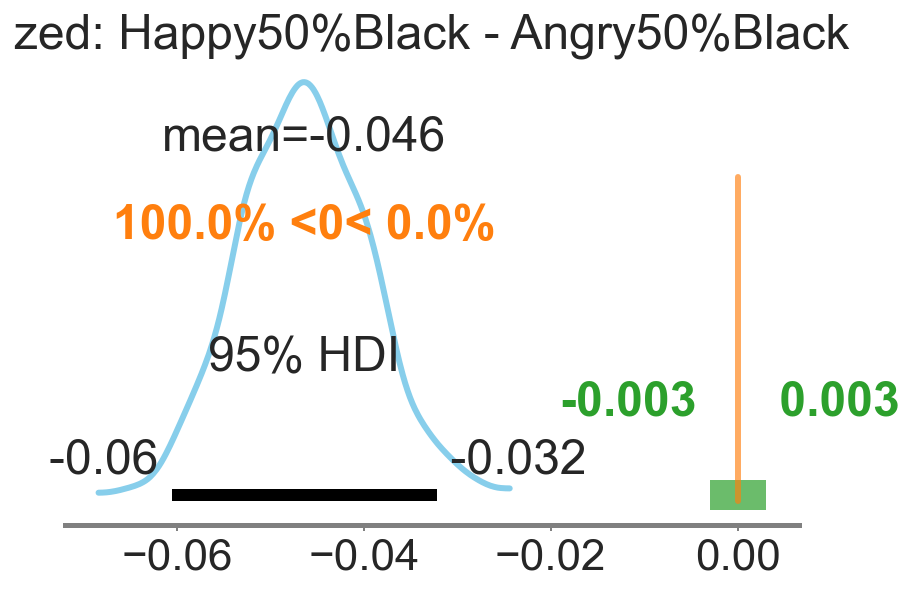

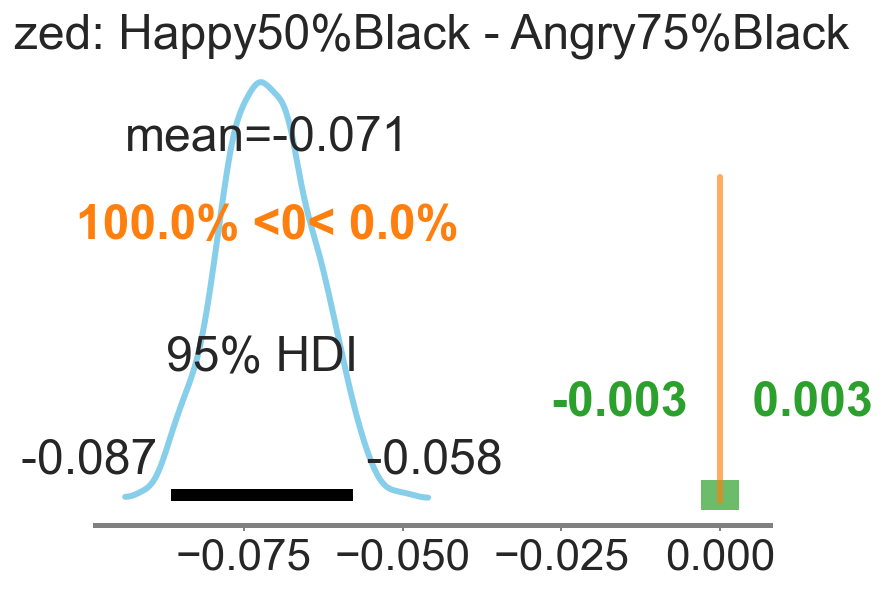

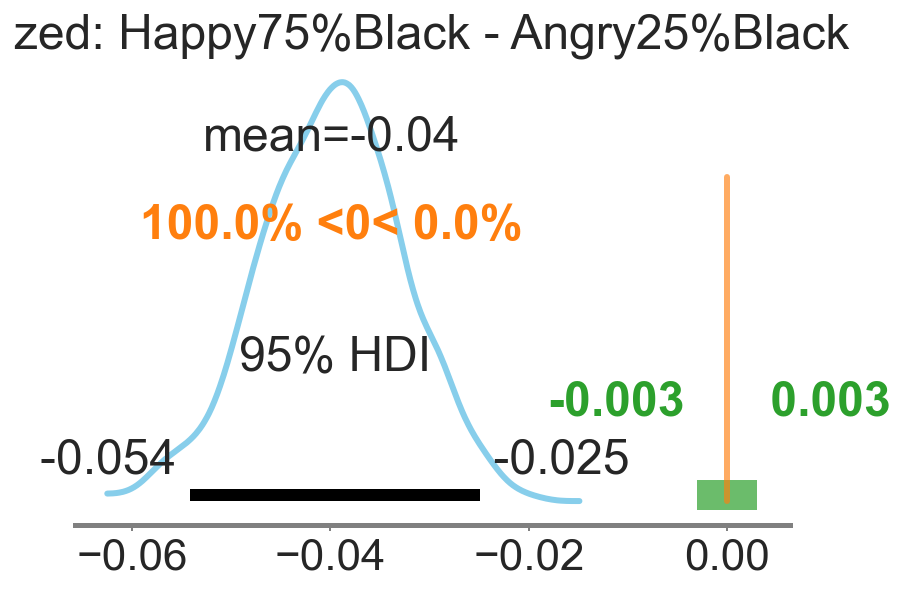

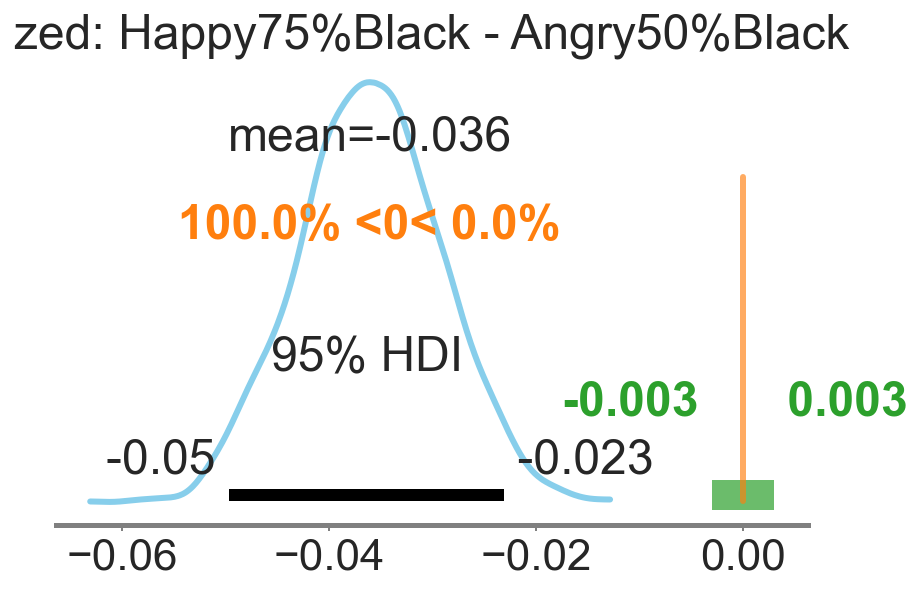

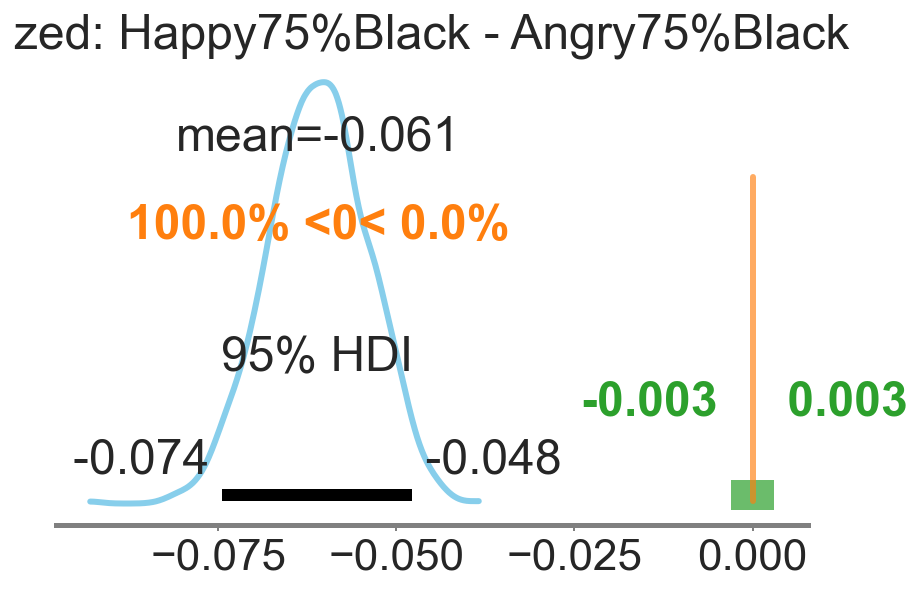

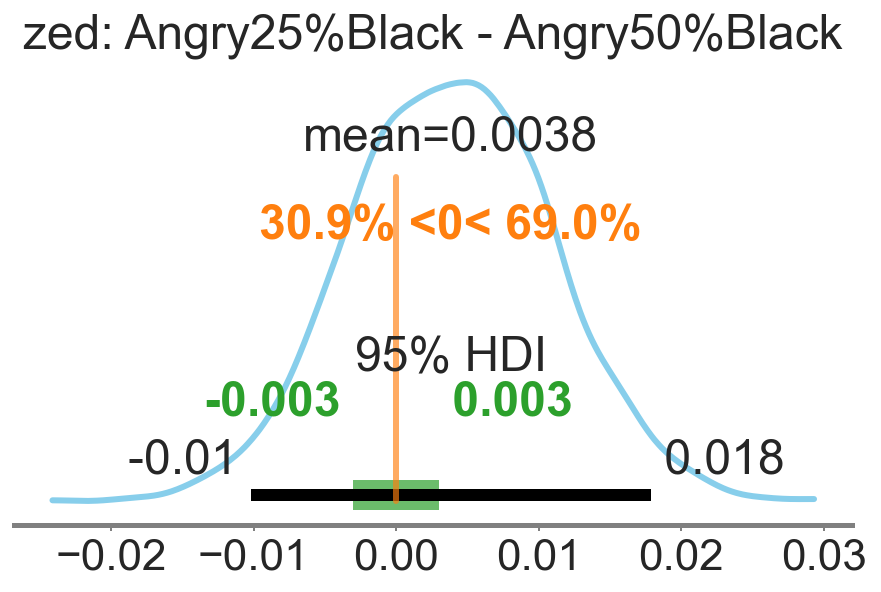

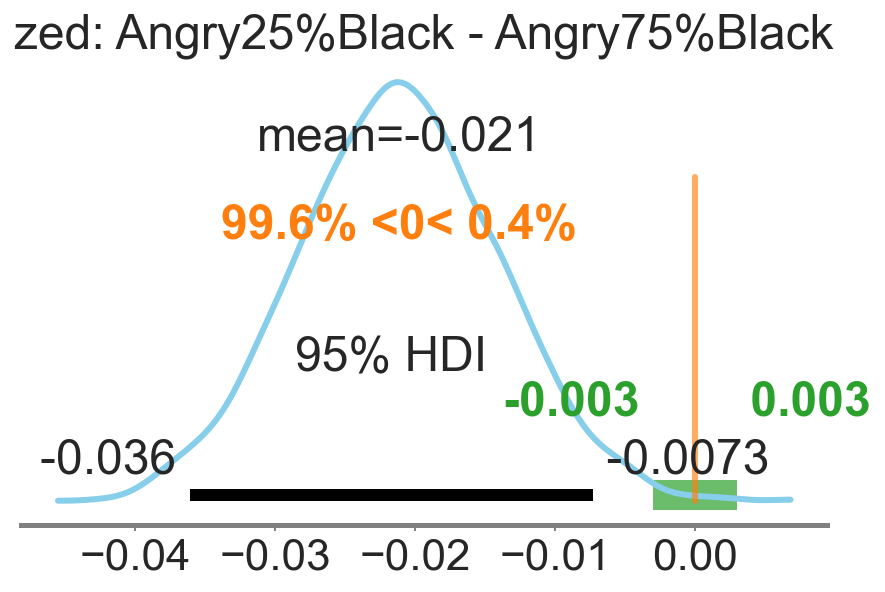

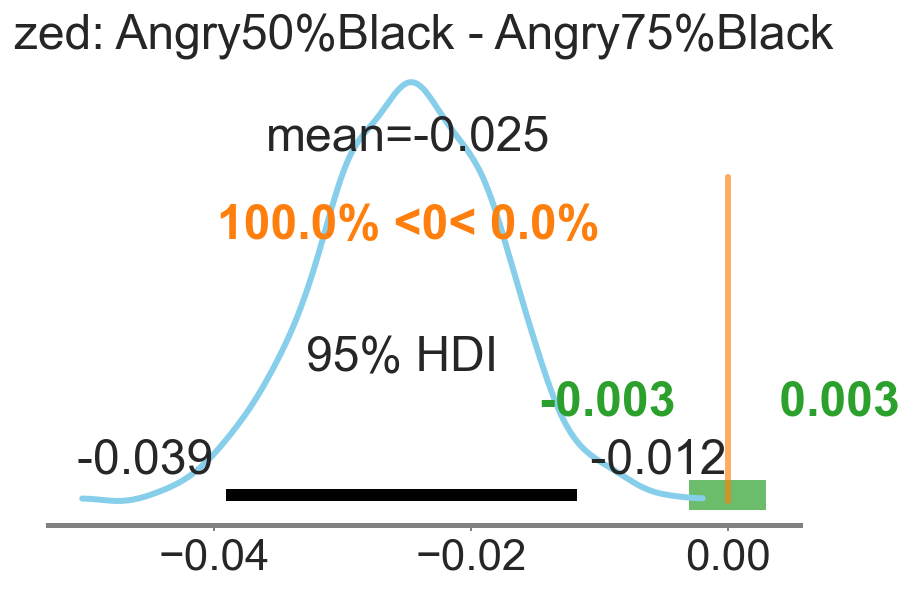

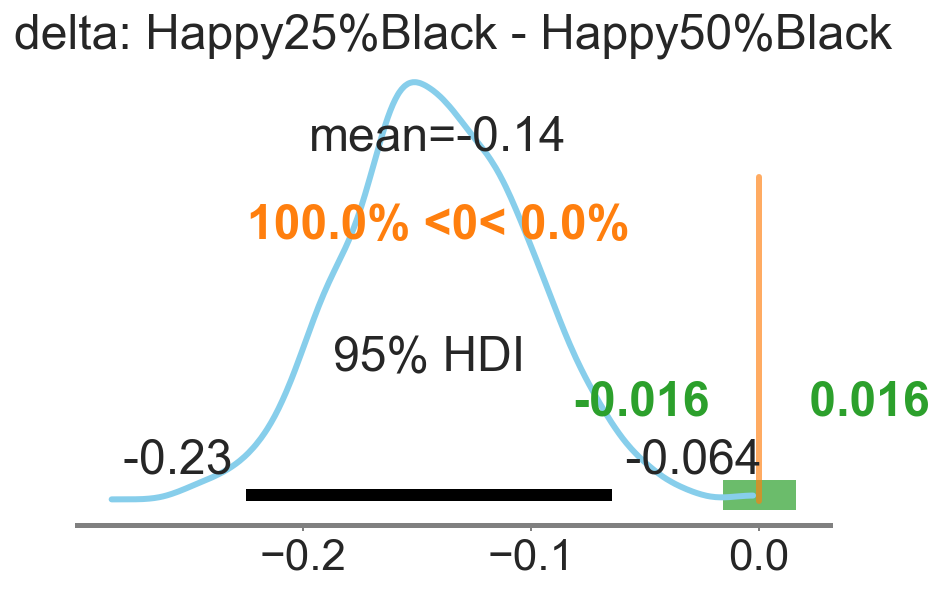

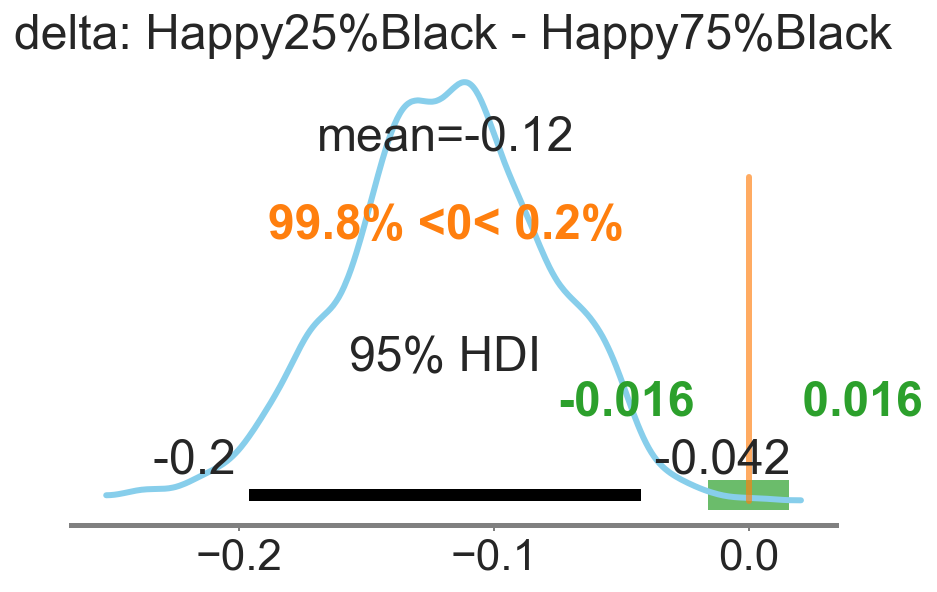

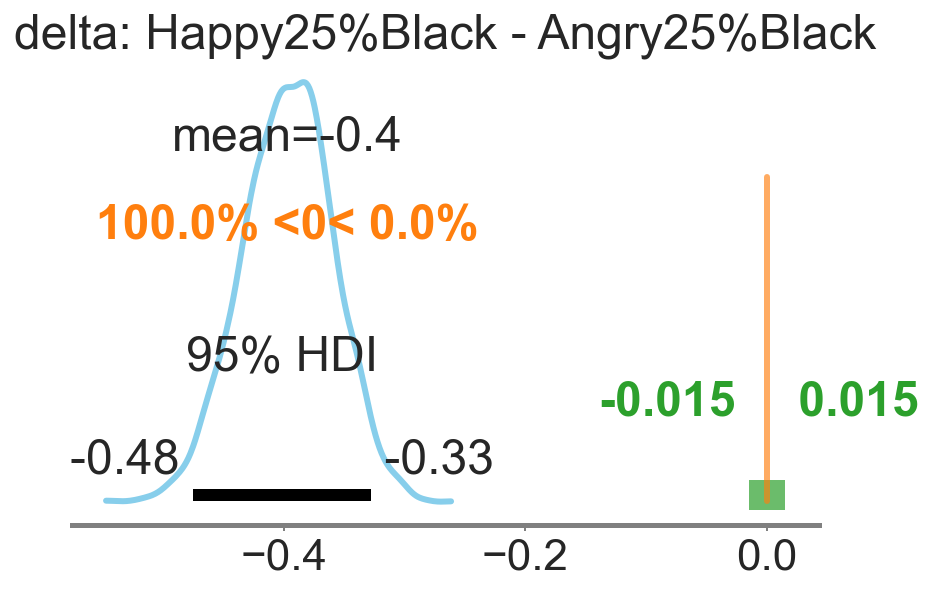

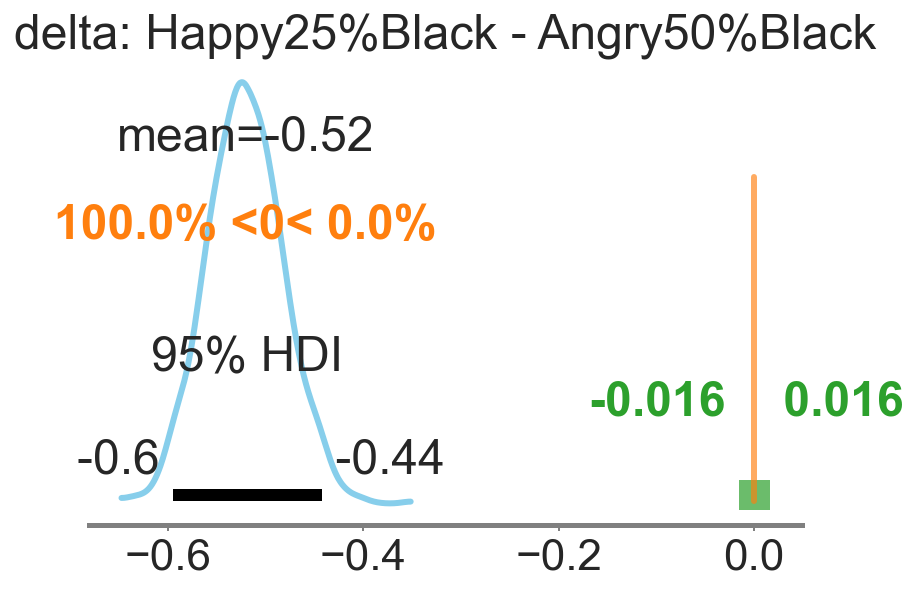

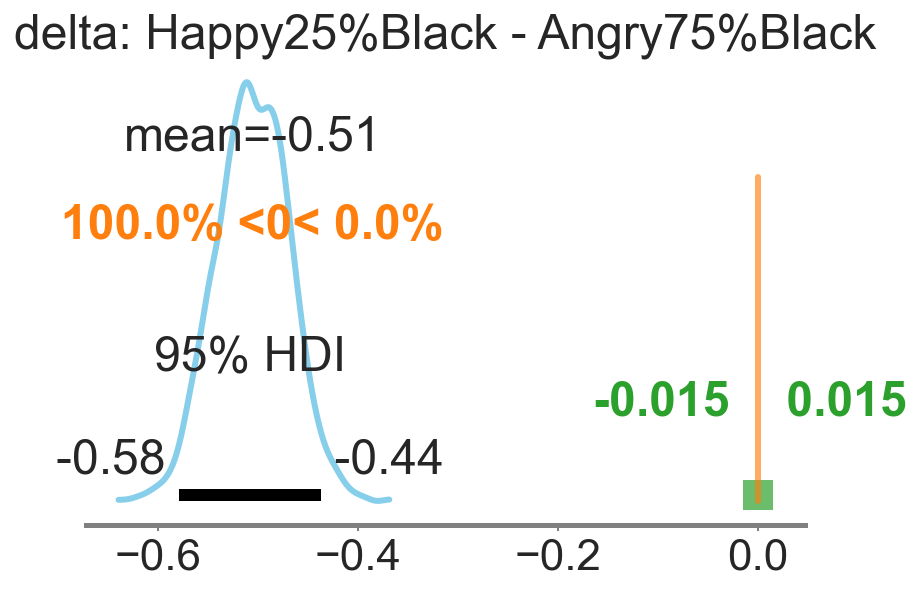

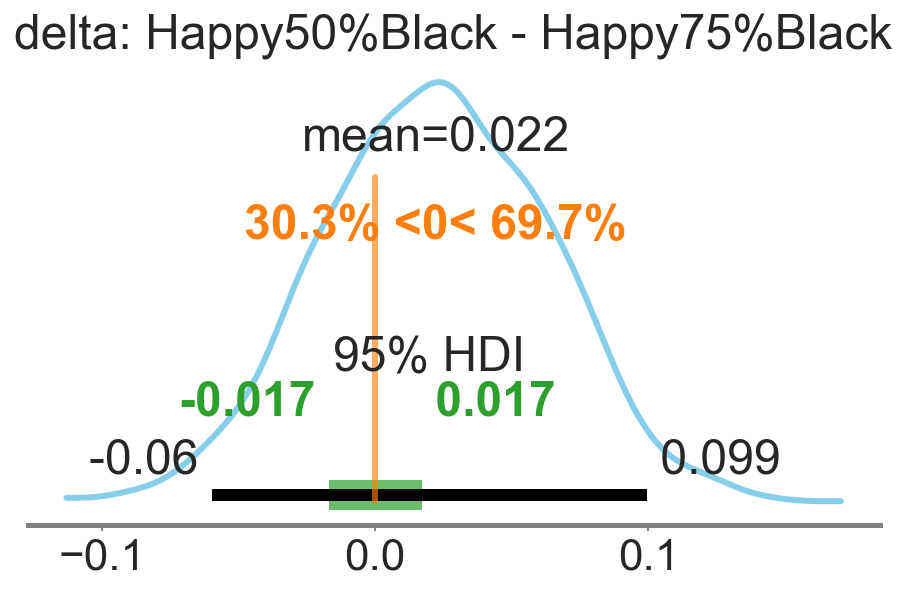

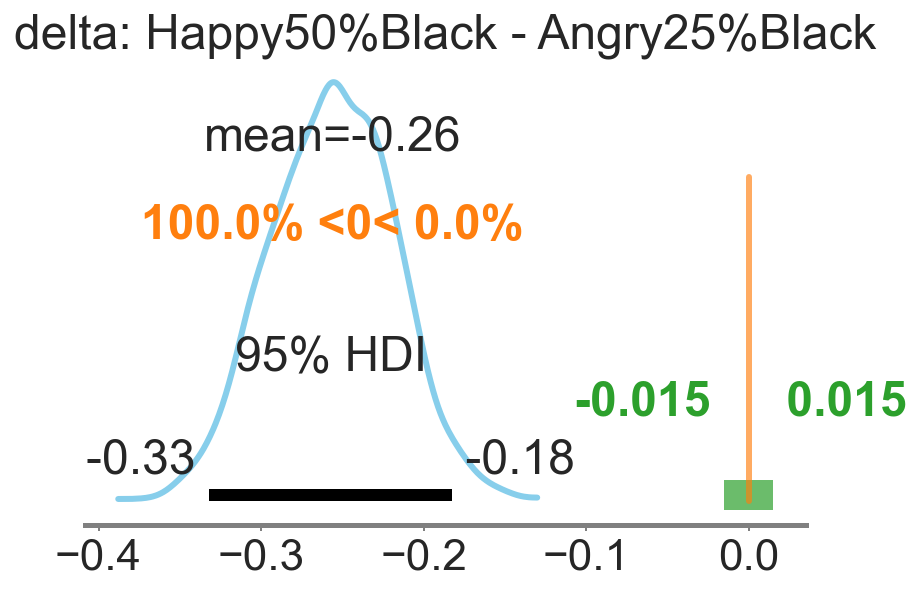

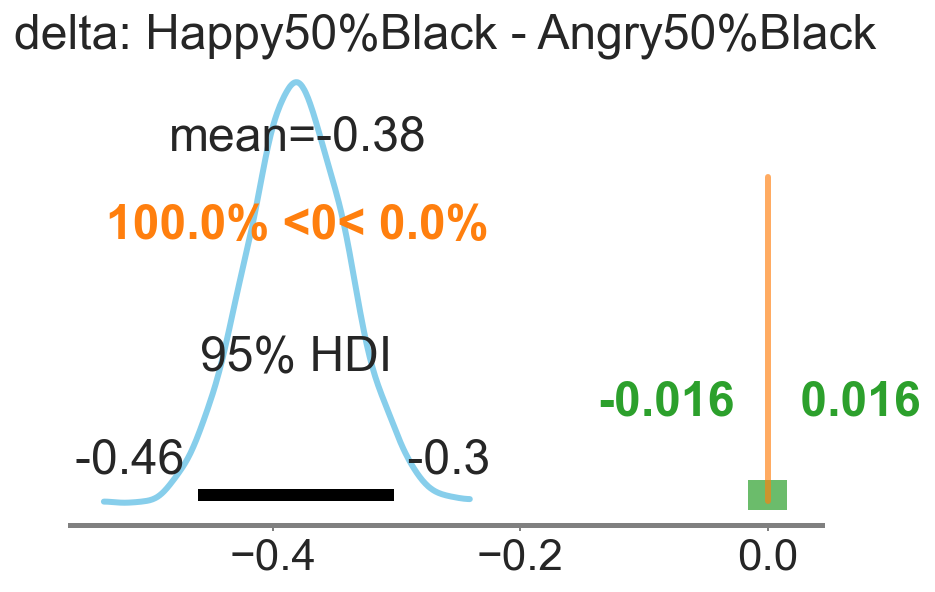

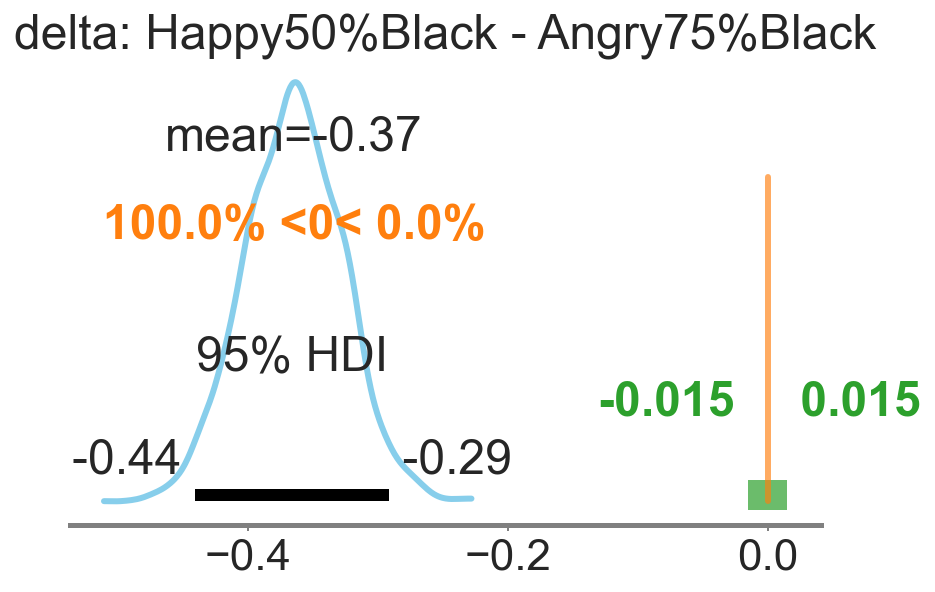

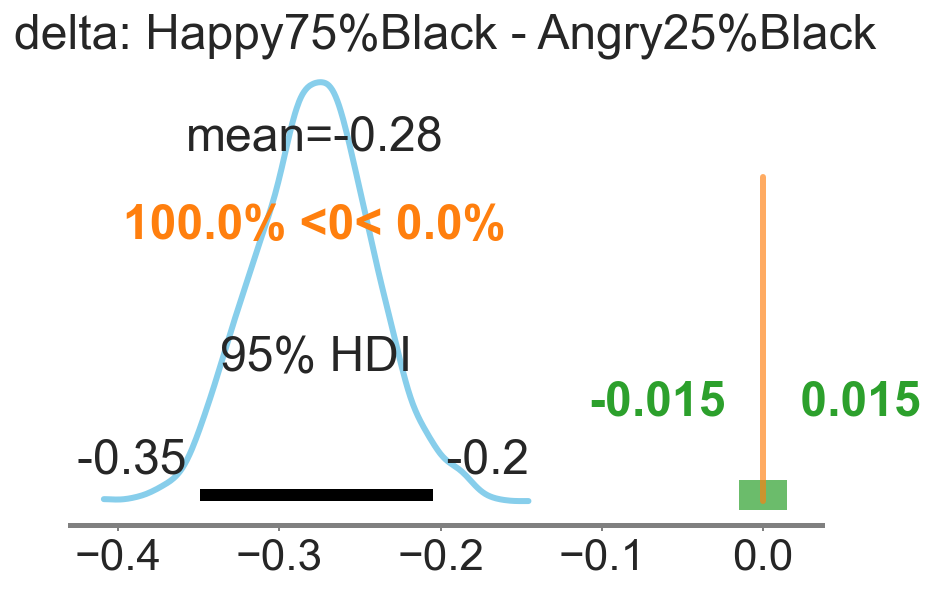

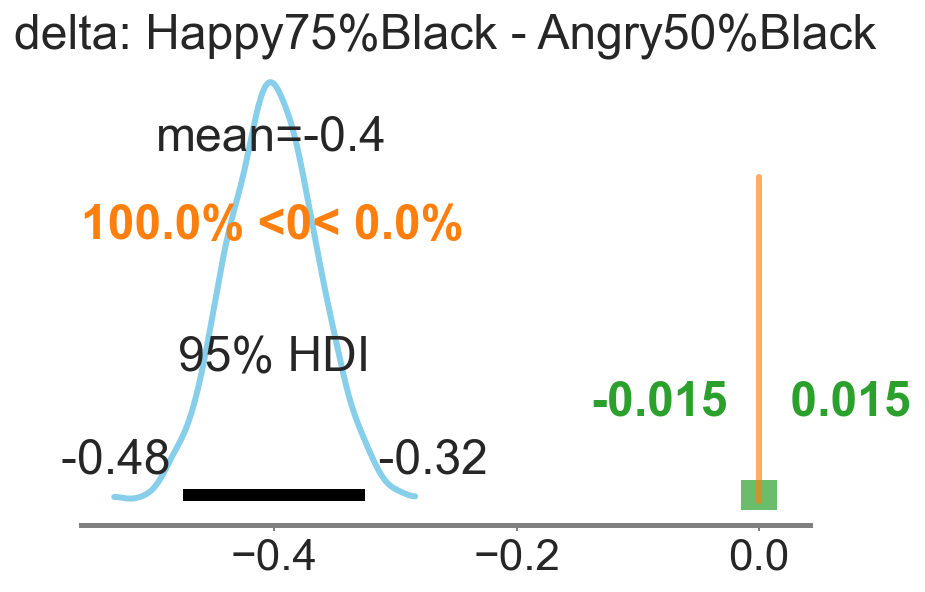

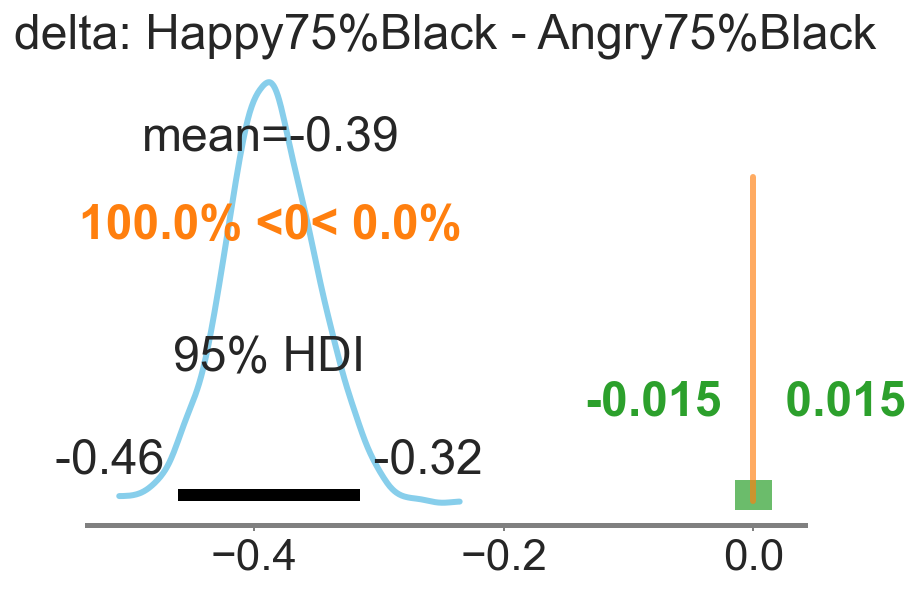

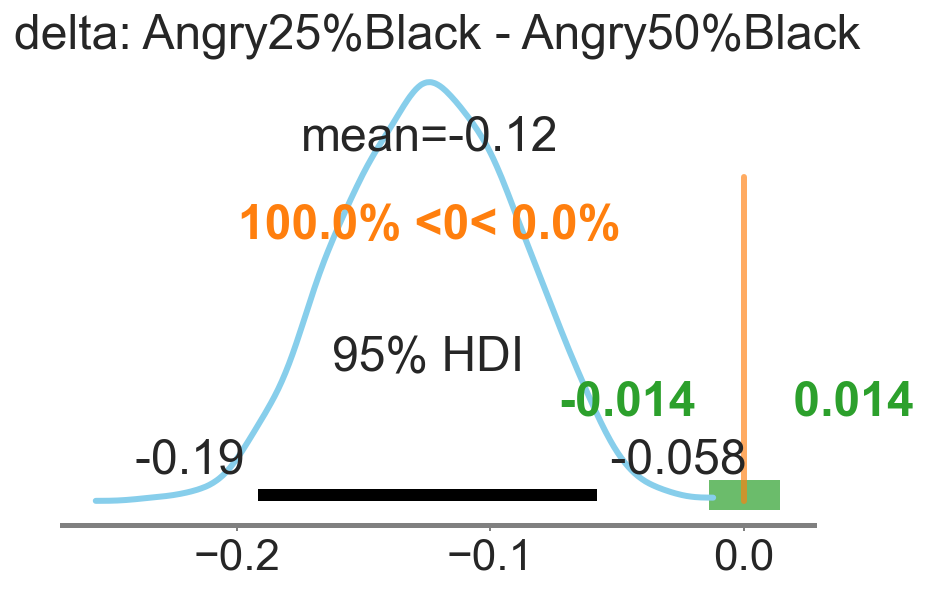

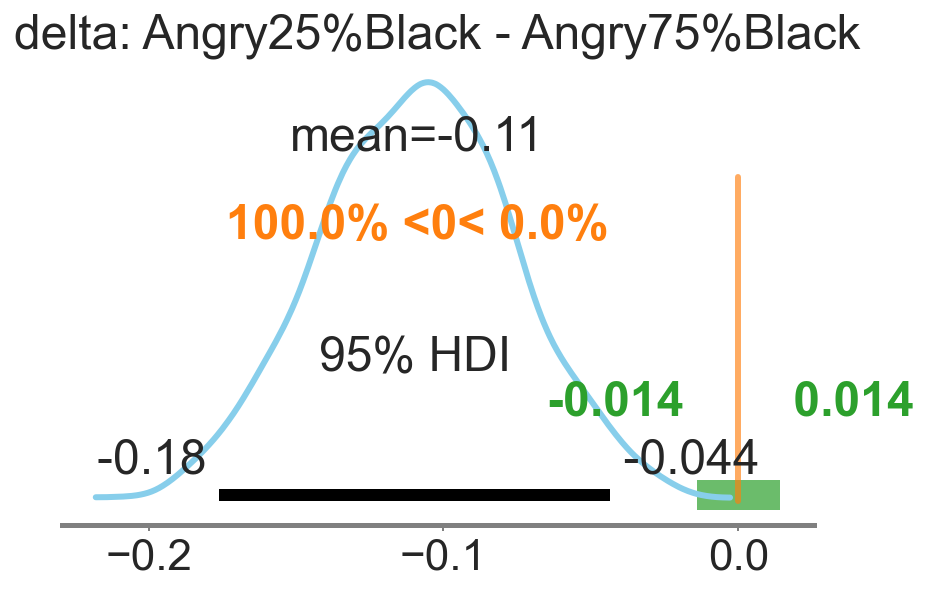

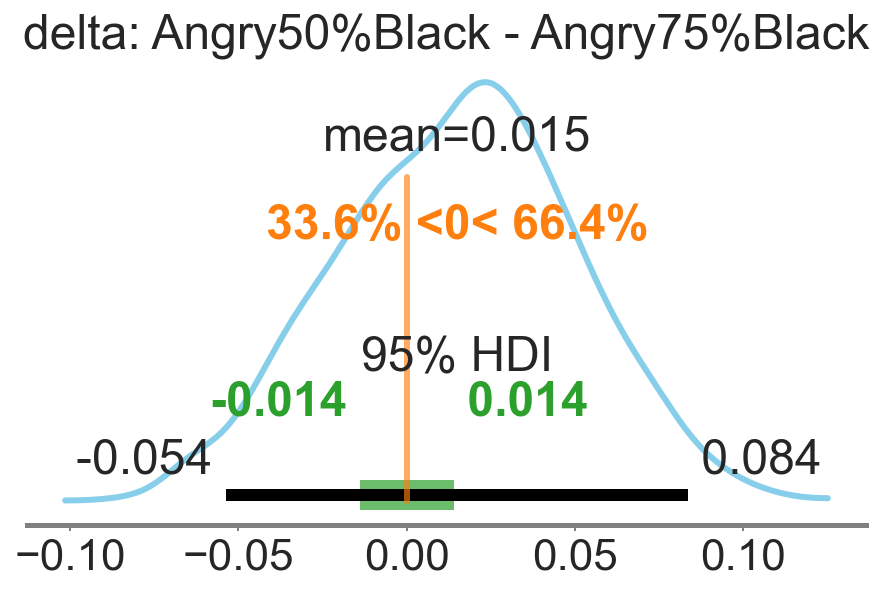

In [35]:
convdict = {'_happy_b25': 'Happy25%Black', '_happy_b50': 'Happy50%Black', '_happy_b75': 'Happy75%Black', 
            '_angry_b25': 'Angry25%Black', '_angry_b50': 'Angry50%Black', '_angry_b75': 'Angry75%Black'}
# convdict = {'mu_}
interdict = {'alpha': ['more drift', 'less drift'], 
            'zed': ['blah', 'blah'],
            'delta': ['blah', 'blah']}
hdint = 0.95
effectsize = 0.8

compdict={}
for x in ['alpha', 'zed', 'delta']:
    compdf = pd.DataFrame({'reference':convdict.values()})
    for i, y in enumerate(convdict.keys()):
        compdftemp = []
        for j, z in enumerate(convdict.keys()):
            if i < j:
                sdf = pd.DataFrame({'mu_'+x+y: azdf3.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                   'mu_'+x+z: azdf3.posterior['mu_'+x+z].mean(dim=['chain']).values})
                var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                rope = [float(round(-(effectsize/2)*stdev(list(var)),3)), float(round((effectsize/2)*stdev(list(var)),3))]
                hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                vart = {'%s: %s' % (x, convdict[y]+' - '+convdict[z]): np.array(var)}
                plot_posterior(vart, color='#87ceeb', 
                  rope=rope, point_estimate='mean',
                  ref_val=0, hdi_prob=hdint)
                if rope[1] < hdi[1]:
                    compdftemp.append(interdict[x][0])
                elif rope[0] > hdi[2]:
                    compdftemp.append(interdict[x][1])
                else:
                    compdftemp.append('=')
            else:
                compdftemp.append('')
        compdf[convdict[y]] = compdftemp
    compdict[x] = compdf

In [61]:
azdf4

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

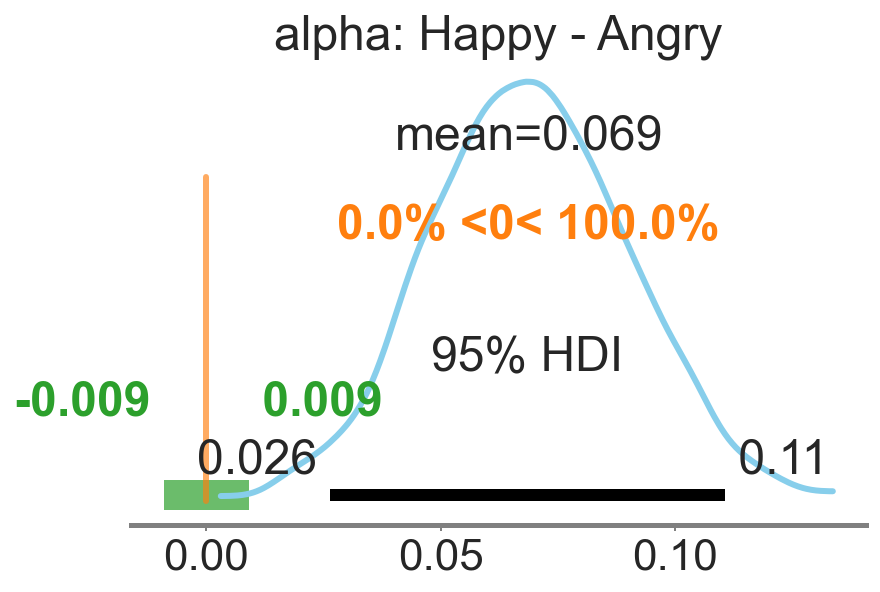

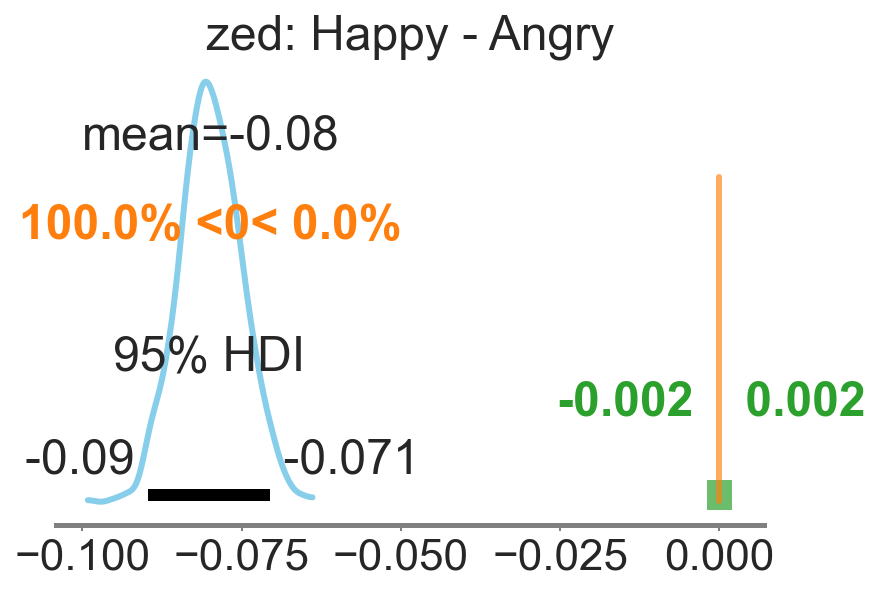

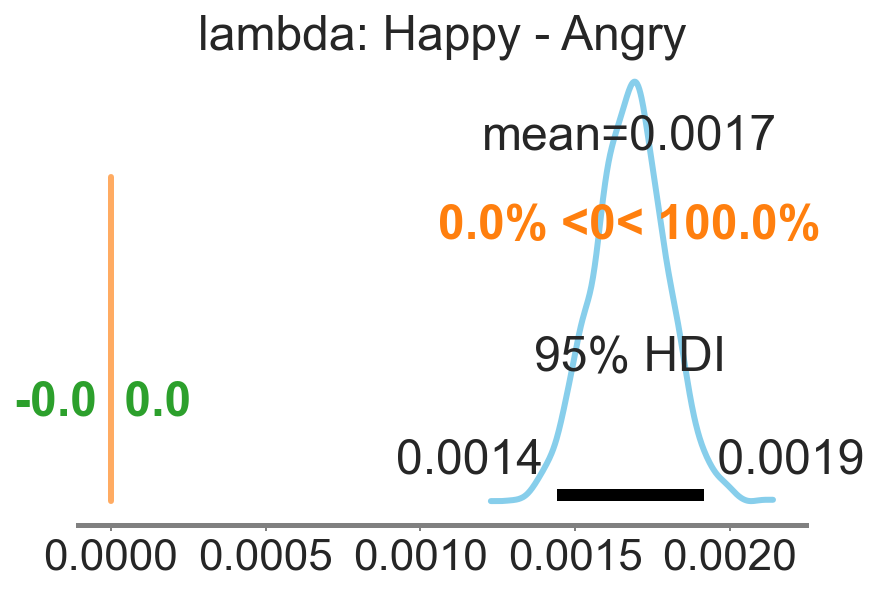

In [34]:
convdict = {'_happy': 'Happy', '_angry': 'Angry'}
# convdict = {'mu_}
interdict = {'alpha': ['more drift', 'less drift'], 
            'zed': ['blah', 'blah'],
            'lambda': ['blah', 'blah']}
hdint = 0.95
effectsize = 0.8

compdict={}
for x in ['alpha', 'zed', 'lambda']:
    compdf = pd.DataFrame({'reference':convdict.values()})
    for i, y in enumerate(convdict.keys()):
        compdftemp = []
        for j, z in enumerate(convdict.keys()):
            if i < j:
                sdf = pd.DataFrame({'mu_'+x+y: azdf4.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                   'mu_'+x+z: azdf4.posterior['mu_'+x+z].mean(dim=['chain']).values})
                var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                rope = [float(round(-(effectsize/2)*stdev(list(var)),3)), float(round((effectsize/2)*stdev(list(var)),3))]
                hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                vart = {'%s: %s' % (x, convdict[y]+' - '+convdict[z]): np.array(var)}
                plot_posterior(vart, color='#87ceeb', 
                  rope=rope, point_estimate='mean',
                  ref_val=0, hdi_prob=hdint)
                if rope[1] < hdi[1]:
                    compdftemp.append(interdict[x][0])
                elif rope[0] > hdi[2]:
                    compdftemp.append(interdict[x][1])
                else:
                    compdftemp.append('=')
            else:
                compdftemp.append('')
        compdf[convdict[y]] = compdftemp
    compdict[x] = compdf

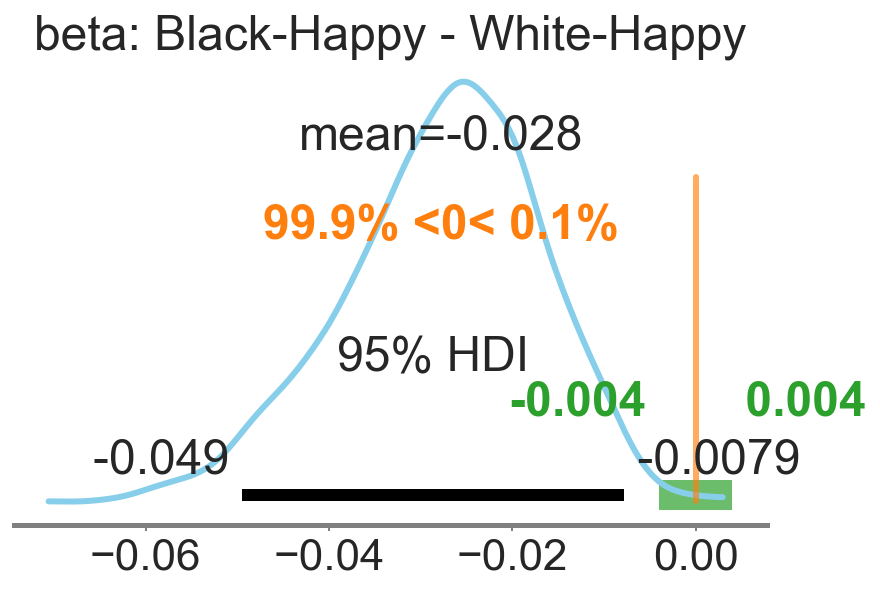

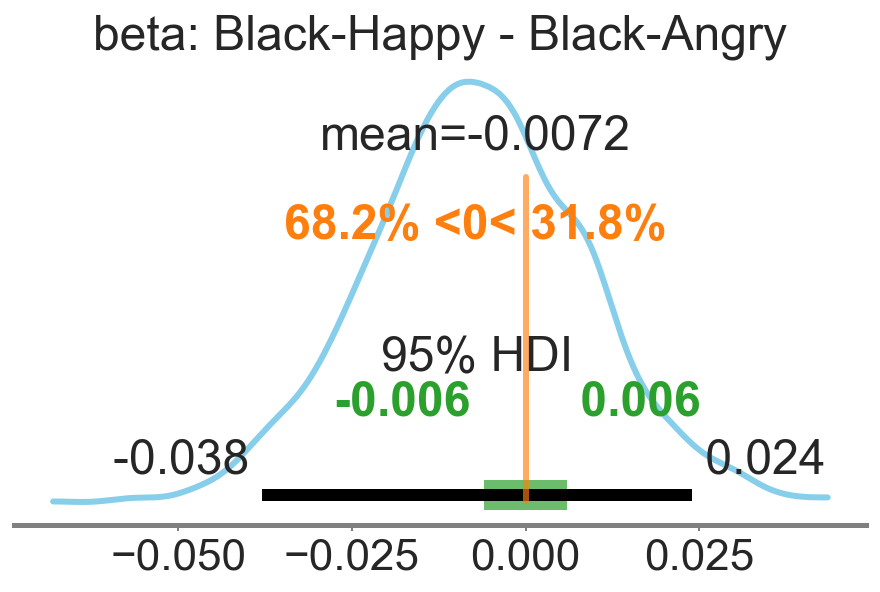

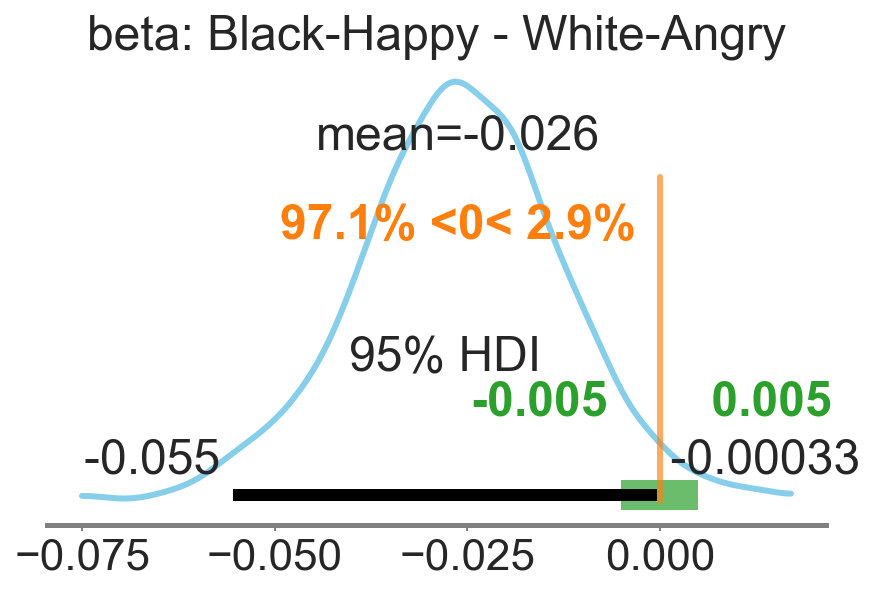

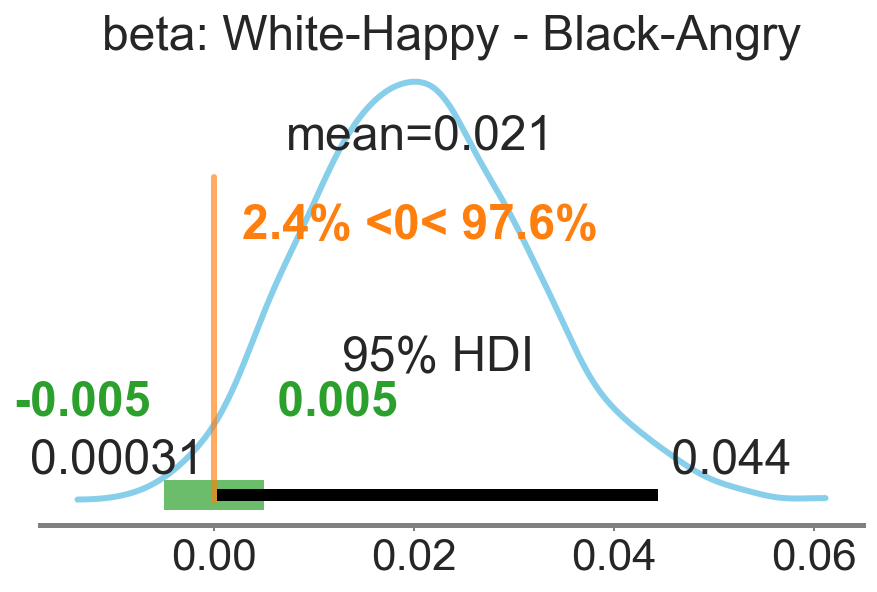

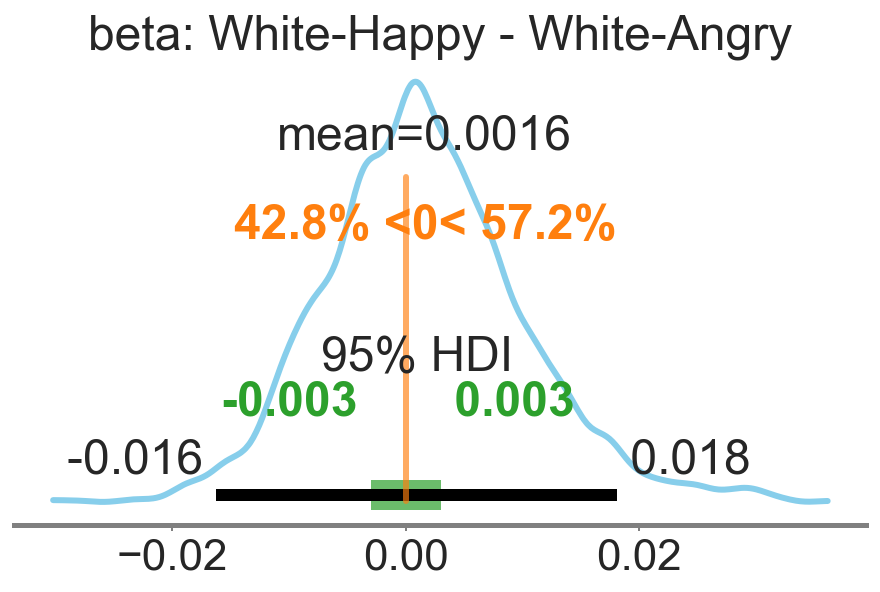

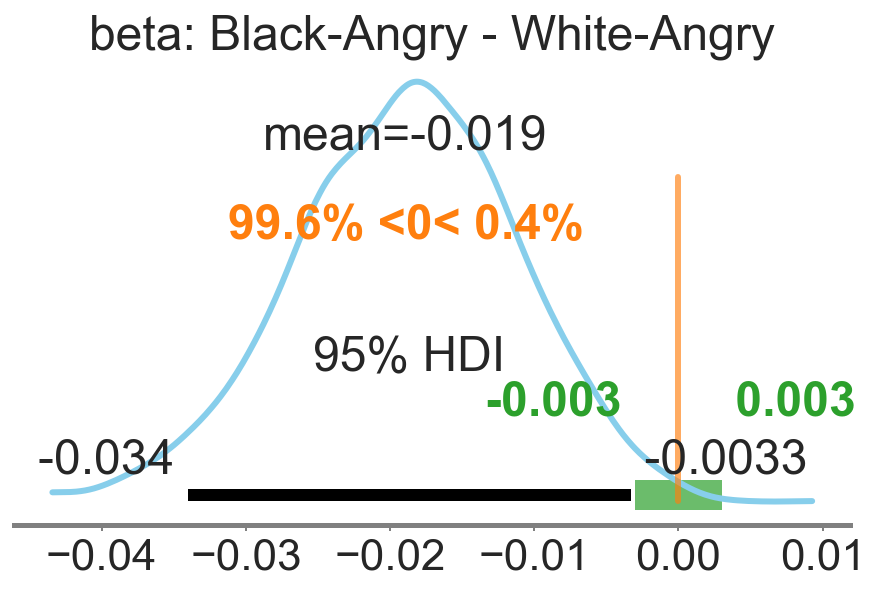

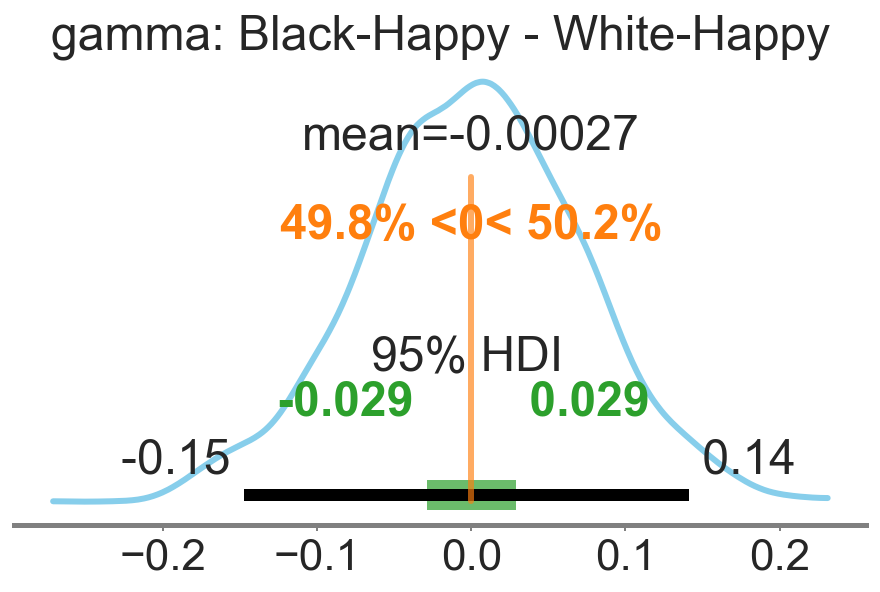

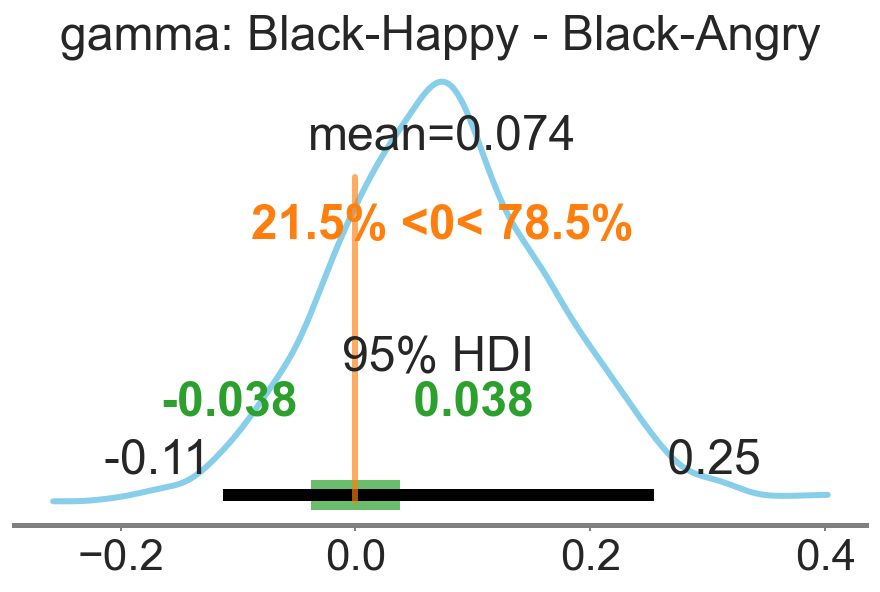

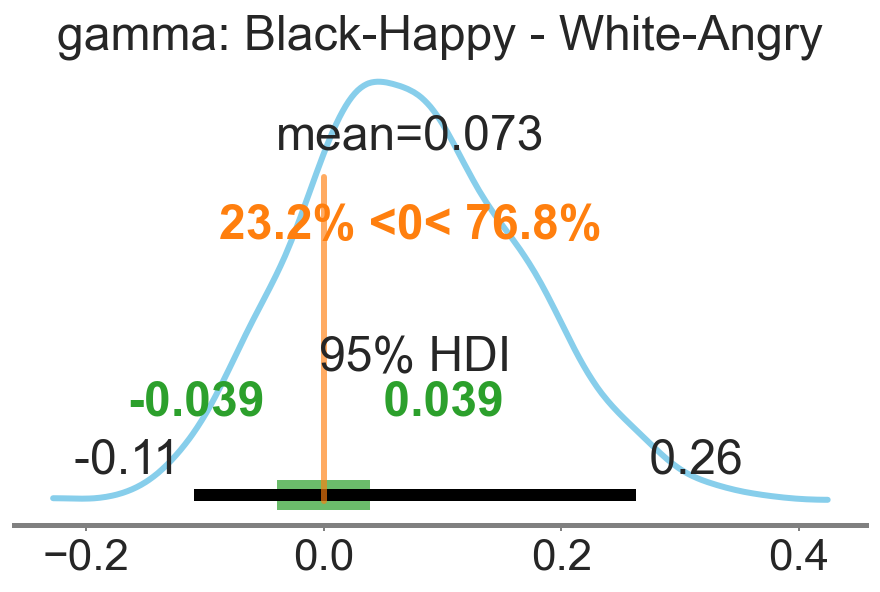

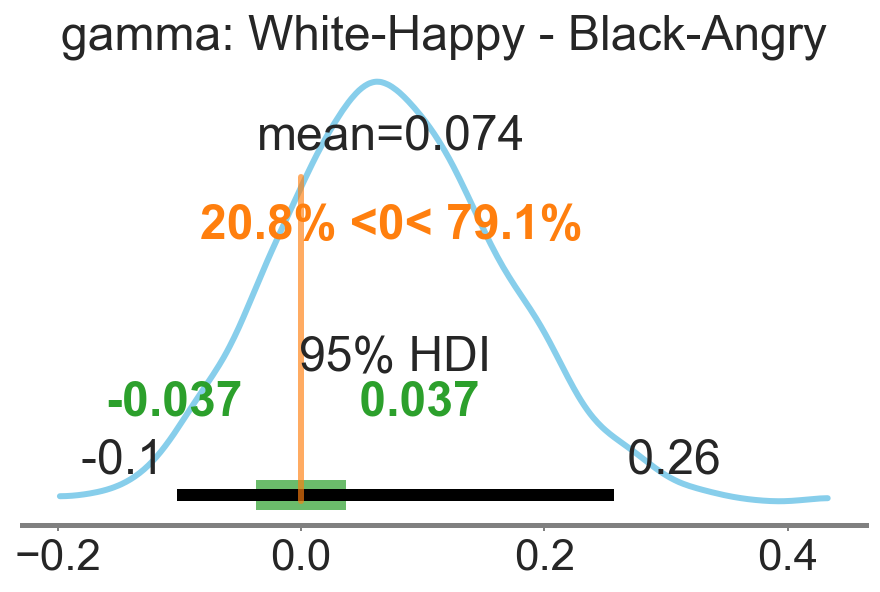

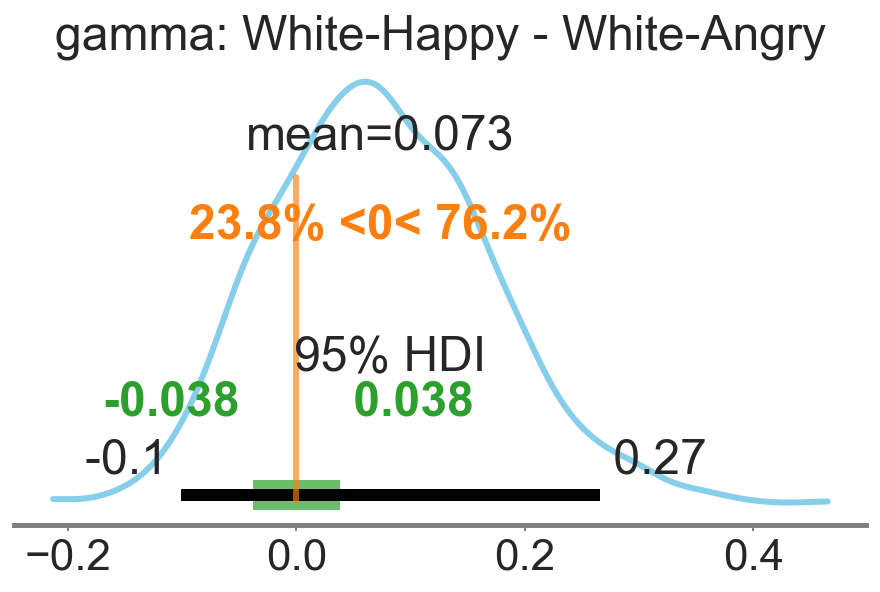

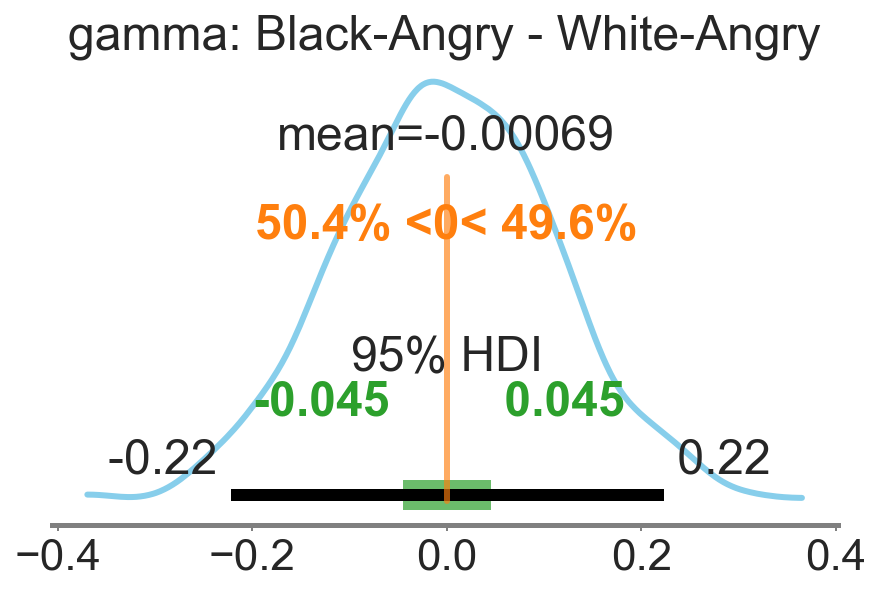

In [31]:
convdict = {'_black_happy': 'Black-Happy', '_white_happy': 'White-Happy', '_black_angry': 'Black-Angry', '_white_angry': 'White-Angry'}
# convdict = {'mu_}
interdict = {'beta': ['more drift', 'less drift'], 
            'gamma': ['blah', 'blah']}
hdint = 0.95
effectsize = 0.8

compdict={}
for x in ['beta', 'gamma']:
    compdf = pd.DataFrame({'reference':convdict.values()})
    for i, y in enumerate(convdict.keys()):
        compdftemp = []
        for j, z in enumerate(convdict.keys()):
            if i < j:
                sdf = pd.DataFrame({'mu_'+x+y: azdf4.posterior['mu_'+x+y].mean(dim=['chain']).values,
                                   'mu_'+x+z: azdf4.posterior['mu_'+x+z].mean(dim=['chain']).values})
                var = sdf['mu_'+x+y] - sdf['mu_'+x+z]
                rope = [float(round(-(effectsize/2)*stdev(list(var)),3)), float(round((effectsize/2)*stdev(list(var)),3))]
                hdi = bayestest.hdi(var, ci=hdint).iloc[0]
                vart = {'%s: %s' % (x, convdict[y]+' - '+convdict[z]): np.array(var)}
                plot_posterior(vart, color='#87ceeb', 
                  rope=rope, point_estimate='mean',
                  ref_val=0, hdi_prob=hdint)
                if rope[1] < hdi[1]:
                    compdftemp.append(interdict[x][0])
                elif rope[0] > hdi[2]:
                    compdftemp.append(interdict[x][1])
                else:
                    compdftemp.append('=')
            else:
                compdftemp.append('')
        compdf[convdict[y]] = compdftemp
    compdict[x] = compdf

## Model Comparison
Here we compare point-wise out-of-sample predictive accuracy between models (Vehtari et al., 2017). This is accomplished by computing leave-one-out cross-validation scores using Pareto smoothed importance sampling. Cross-validation scores reflect expected log point-wise predictive densities weighted with penalty terms controlling for both a model’s goodness of fit to the data and the complexity of the model.<br /><br />
Higher loo means better fit. Here, we see that the symmetric model better fits the data.

In [62]:
compdf = az.compare({'standard': azdf1, 'standard+racedelta': azdf2, 'standard+race+valence': azdf3,
                    'extended': azdf4}, ic='waic')
# compdf = az.compare({'standard': azdf1, 'standard+racedelta': azdf2, 'standard+race+valence': azdf3}, ic='waic')
compdf

rank          waic       p_waic       d_waic weight  \
extended                 0  -9818.555379    947.66324          0.0    NaN   
standard+race+valence    1 -12894.539574  1978.540587  3075.984195    NaN   
standard                 2 -13045.637866   897.109494  3227.082487    0.0   
standard+racedelta       3 -13549.652006   895.812725  3731.096627    0.0   

                               se         dse warning waic_scale  
extended               536.183985         0.0    True        log  
standard+race+valence  550.929593  190.476476    True        log  
standard               533.392958  102.033079    True        log  
standard+racedelta     443.843161   72.794399    True        log

<AxesSubplot:xlabel='Log'>

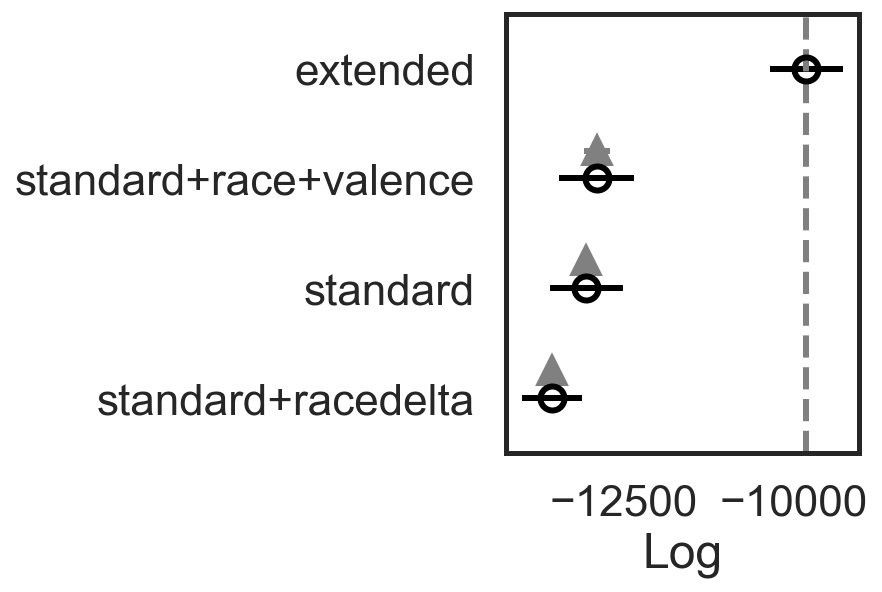

In [63]:
az.plot_compare(compdf, insample_dev=False)
# az.plot_compare(compdf)

100%|███████████████████████████████████████████████████████████████████████████████| 620/620 [00:00<00:00, 903.55it/s]


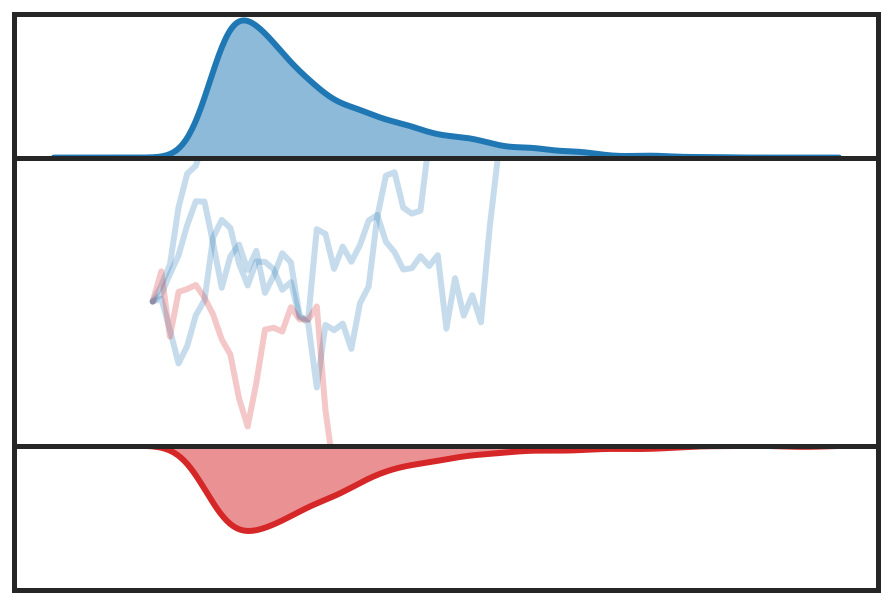

In [116]:
"""Create a DDM figure.

"""
import hddm
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm


def setupfig():
    """Tweak for the target journal.

    """
    fig = plt.figure()
    gs = GridSpec(3, 1, height_ratios=[1, 2, 1], hspace=0)
    return fig, gs


def delabel(ax):
    """Strip labels.

    """
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])


def kde(ax, x, mx, c):
    """Plot a KDE for reaction times.

    """
    x = x[x <= mx]
    bandwidth = 0.8 * x.std() * x.size ** (-1 / 5.0)
    support = np.linspace(0, mx, 500)
    kernels = []

    for x_i in tqdm(x):

        kernel = norm(x_i, bandwidth).pdf(support)
        kernels.append(kernel)
        density = np.sum(kernels, axis=0)

    my = np.max(density)
    ax.plot(support, density, c=c)
    ax.fill_between(support, 0, density, alpha=0.5, facecolor=c)
    ax.set_ylim(0, my * 1.05)
    delabel(ax)

    return my


def traces(ax, n, mx, **params):
    """Draw example diffusions.

    """
    x = np.linspace(0, mx, 101)
    delta = x[1]
    nd_samples = np.round(params["t"] / delta).astype(int)
    d_samples = len(x) - nd_samples
    y0 = np.zeros(nd_samples) * np.nan
    y0[-1] = 0

    for i in range(n):

        y1 = np.cumsum(norm.rvs(params["v"] * delta, np.sqrt(delta), size=d_samples))
        y = params["a"] * params["z"] + np.concatenate([y0, y1])

        try:

            idx1 = np.where(y > params["a"])[0][0] + 1

        except:

            idx1 = np.inf

        try:

            idx2 = np.where(y < 0)[0][0] + 1

        except:

            idx2 = np.inf

        if idx1 < idx2:

            y[idx1:] = np.nan
            ax.plot(x, y, c="C0", zorder=-12, alpha=0.25)

        if idx2 < idx1:

            y[idx2:] = np.nan
            ax.plot(x, y, c="C3", zorder=-11, alpha=0.25)

        ax.set_ylim(0, params["a"])
        ax.set_xlim(0, mx)
        delabel(ax)


def ddmfig(**params):
    """Draw a DDM plot with the given parameter values.

    """
    mx = 3.5  # max x-value; adjust this if simulated RTs are slower/faster
    size = 1500  # increase this number for better KDEs
    ntraces = 4  # increase this for more example diffusions

    # set up fig
    fig, gs = setupfig()

    # traces
    ax = plt.subplot(gs[1])
    traces(ax, ntraces, mx, **params)

    # data for kdes
    df, _ = hddm.generate.gen_rand_data(params, subjs=1, size=size)

    # top KDE
    ax = plt.subplot(gs[0])
    my = kde(ax, df[df.response == 1].rt.values, mx, "C0")

    # bottom KDE
    ax = plt.subplot(gs[2])
    kde(ax, df[df.response == 0].rt.values, mx, "C3")
    ax.set_ylim(0, my * 1.05)
    ax.invert_yaxis()

    # remove whitespace around fig
    plt.tight_layout(0)


def main():

#     np.random.seed(25)
    ddmfig(v=0.3, a=1.5, t=0.6, z=0.5)

if __name__ == "__main__":

    main()

In [500]:
x = np.linspace(-150,150)
y = np.exp(x/30)
z = np.exp((-(x-200)/38))
w = np.exp(x/35)
p = np.exp((-(x-200)/29))

(0.0, 150.0)

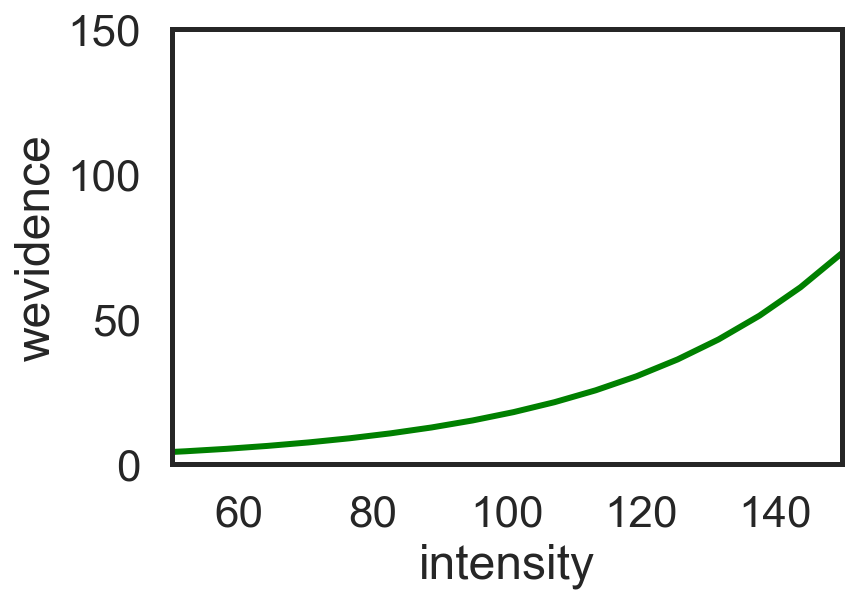

In [505]:
tempdf = pd.DataFrame({'intensity': x, 'evidence': y, 'zevidence': z, 'wevidence': w, 'pevidence': p})
# sns.lineplot('intensity', 'evidence', data=tempdf, color='blue')
# sns.lineplot('intensity', 'zevidence', data=tempdf)
sns.lineplot('intensity', 'wevidence', data=tempdf, color='green')
# sns.lineplot('intensity', 'pevidence', data=tempdf)

# plt.xlabel('intensity')
# plt.ylabel('evidence')
plt.xlim(50, 150)
plt.ylim(0, 150)